# Imports

In [1]:
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
from tensorflow import keras
import pickle
from datetime import datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
import calendar
import collections.abc
collections.Iterable = collections.abc.Iterable
warnings.filterwarnings("ignore")

2023-04-05 22:16:13.271661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 22:16:29.906243: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-05 22:16:29.906343: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-05 22:16:29.906351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-05 22:16:50.820050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 22:16:55.337013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 22:16:55.337502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Data Ingestion and Preparation

In [3]:
train = pd.read_csv('train.csv', index_col='date')
train.index = pd.to_datetime(train.index)
train = pd.pivot_table(train, values='sales', index="date", columns=['store_nbr', 'family'], aggfunc=np.sum)
train.columns = [f"{a[0]}_{a[1].replace('/','_')}" for a in train.columns]
test = pd.read_csv('test.csv', index_col='date')
test.index = pd.to_datetime(test.index)

In [4]:
X = train
Y = train.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], 1782, 1)
y_test = y_test.values.reshape(y_test.shape[0], 1782, 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1515, 1782, 1)
(169, 1782, 1)
(1515, 1782, 1)
(169, 1782, 1)


# RNN model

In [5]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=10, min_delta=0.05)

In [6]:
rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1)
])
rnn.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
rnn.summary()
rnn.fit(X_train, y_train, epochs=100, callbacks=[es])
pred_rnn = abs(rnn.predict(X_test))

2023-03-24 04:06:37.073628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 04:06:37.113930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 04:06:37.114109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 04:06:37.114234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1782, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1782, 100)         20100     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1782, 100)         20100     
                                                                 
 dense (Dense)               (None, 1782, 1)           101       
                                                                 
Total params: 50,501
Trainable params: 50,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-03-24 04:06:56.840794: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f54f80a3df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-24 04:06:56.840817: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-03-24 04:06:57.294648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-24 04:07:00.242718: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 116s 2s/step - loss: 6.0806
Epoch 2/100
48/48 [==============================] - 101s 2s/step - loss: 4.6425
Epoch 3/100
48/48 [==============================] - 99s 2s/step - loss: 4.1946
Epoch 4/100
48/48 [==============================] - 103s 2s/step - loss: 3.8735
Epoch 5/100
48/48 [==============================] - 99s 2s/step - loss: 3.6313
Epoch 6/100
48/48 [==============================] - 102s 2s/step - loss: 3.4365
Epoch 7/100
48/48 [==============================] - 103s 2s/step - loss: 3.2719
Epoch 8/100
48/48 [==============================] - 103s 2s/step - loss: 3.1355
Epoch 9/100
48/48 [==============================] - 103s 2s/step - loss: 3.0148
Epoch 10/100
48/48 [==============================] - 100s 2s/step - loss: 2.9126
Epoch 11/100
48/48 [==============================] - 98s 2s/step - loss: 2.8209
Epoch 12/100
48/48 [==============================] - 102s 2s/step - loss: 2.7344
Epoch 13/100
48/48 [====================

In [7]:
print(pred_rnn.shape)
pred_rnn

(169, 1782, 1)


array([[[3.13162565e+00],
        [9.40127015e-01],
        [2.00550175e+00],
        ...,
        [1.45430588e+02],
        [3.17476392e-01],
        [2.26822281e+00]],

       [[2.24591827e+00],
        [5.26040673e-01],
        [2.50926733e+00],
        ...,
        [1.45397507e+02],
        [1.20865226e-01],
        [4.25453234e+00]],

       [[2.24816799e+00],
        [1.77690613e+00],
        [4.00327110e+00],
        ...,
        [1.45381683e+02],
        [6.58118725e-03],
        [3.22148848e+00]],

       ...,

       [[2.24591827e+00],
        [5.26040673e-01],
        [1.56741512e+00],
        ...,
        [1.45417084e+02],
        [1.46332145e-01],
        [1.72440135e+00]],

       [[2.24591827e+00],
        [5.26040673e-01],
        [3.88898182e+00],
        ...,
        [1.45358627e+02],
        [2.57499814e-01],
        [9.13275123e-01]],

       [[2.16028833e+00],
        [2.56163025e+00],
        [2.53426933e+00],
        ...,
        [1.45443069e+02],
        [2.1512

In [8]:
pred_rnn = pred_rnn.reshape(169, 1782)
pred = pd.DataFrame(pred_rnn, columns=X.columns, index=X_test_index)
pred

1_AUTOMOTIVE  1_BABY CARE  1_BEAUTY  1_BEVERAGES   1_BOOKS  \
date                                                                     
2017-02-28      3.131626     0.940127  2.005502   145.434113  0.723986   
2017-03-01      2.245918     0.526041  2.509267   145.427948  0.678250   
2017-03-02      2.248168     1.776906  4.003271   145.436111  0.606269   
2017-03-03      2.914533     3.234763  3.995429   145.436096  0.566793   
2017-03-04      4.358467     3.823153  2.740965   145.441376  1.010905   
...                  ...          ...       ...          ...       ...   
2017-08-11      2.245918     0.526041  1.567415   145.418915  0.753632   
2017-08-12      4.358467     3.823153  2.244023   145.441757  0.729004   
2017-08-13      2.245918     0.526041  1.567415   145.403503  0.667285   
2017-08-14      2.245918     0.526041  3.888982   145.422012  0.607723   
2017-08-15      2.160288     2.561630  2.534269   145.440750  0.717179   

            1_BREAD_BAKERY  1_CELEBRATION  1_CLEANING     1_DAIRY      1_DELI  \
date                                                                            
2017-02-28      140.116959       5.003486  145.139725  145.373474   71.816170   
2017-03-01      145.433578      10.277312  145.456665  145.445923  139.475922   
2017-03-02      145.419601      12.379835  145.455933  145.441650  123.874817   
2017-03-03      145.430206      12.426010  145.457001  145.443802  143.139572   
2017-03-04      145.415543       6.325305  145.452744  145.446014  119.882843   
...                    ...            ...         ...         ...         ...   
2017-08-11      141.644424       4.268618  145.260178  145.374222   71.444656   
2017-08-12      145.055649       4.478680  145.378296  145.426346   97.092743   
2017-08-13      140.890823       2.674837  144.439148  145.024490   63.470299   
2017-08-14      145.385345       5.850714  145.443359  145.435928  136.764877   
2017-08-15      145.363846      10.397854  145.452011  145.442413  114.731316   

            ...  54_MAGAZINES   54_MEATS  54_PERSONAL CARE  54_PET SUPPLIES  \
date        ...                                                               
2017-02-28  ...      0.518683  66.644104        144.901810         0.004436   
2017-03-01  ...      1.105945  72.876984        145.120300         1.243461   
2017-03-02  ...      0.781112  62.935173        145.108673         0.047902   
2017-03-03  ...      1.089380  68.952583        145.014313         0.056733   
2017-03-04  ...      1.037950  62.837872        145.242538         0.199756   
...         ...           ...        ...               ...              ...   
2017-08-11  ...      0.223201  69.100510        144.433044         0.104697   
2017-08-12  ...      0.735446  67.227753        144.752991         0.168197   
2017-08-13  ...      1.250850  75.816154        145.118225         0.176121   
2017-08-14  ...      0.968763  70.766930        144.930847         0.048873   
2017-08-15  ...      1.389166  75.944641        144.125397         0.555154   

            54_PLAYERS AND ELECTRONICS  54_POULTRY  54_PREPARED FOODS  \
date                                                                    
2017-02-28                    4.759746   72.591469          59.596935   
2017-03-01                    3.111595   65.667503          51.362659   
2017-03-02                    2.605171   67.659134          53.652061   
2017-03-03                    3.196102   67.260086          55.418373   
2017-03-04                    3.476664   42.056442          72.074326   
...                                ...         ...                ...   
2017-08-11                    0.860183   95.807304          45.943996   
2017-08-12                    2.932226   99.225273          68.615211   
2017-08-13                    2.848880   77.431404          68.085701   
2017-08-14                    2.260239   65.476616          94.536369   
2017-08-15                    2.672468   84.138161          79.220558   

            54_PR

In [10]:
def compare(column):
    df_test = X_test_copy[column]
    prediction = pred[column]
    df_test.plot(figsize=(25, 10))
    prediction.plot()
    print(f"R2 Score: {r2_score(df_test, prediction)}")
    print(f"RMSLE: {mean_squared_log_error(df_test, prediction, squared=False)}")

R2 Score: -5.629140728908288
RMSLE: 0.7509619060115394


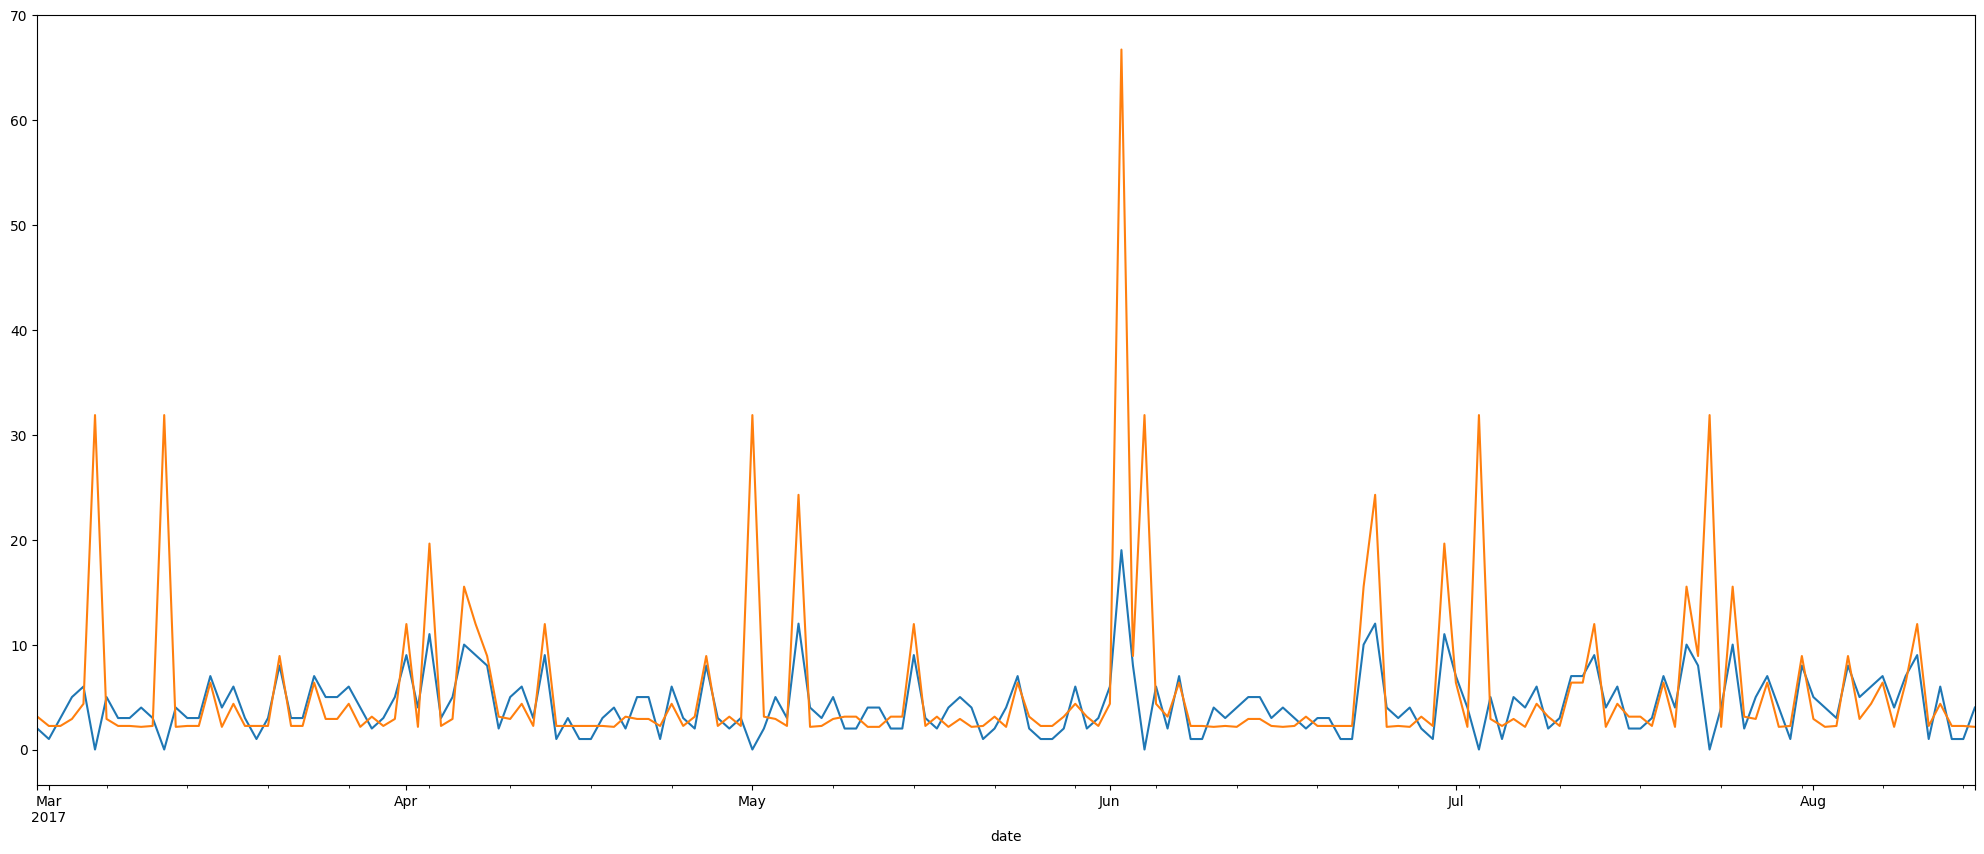

In [10]:
compare('1_AUTOMOTIVE')

R2 Score: -5.45355294627636
RMSLE: 1.4965529644100983


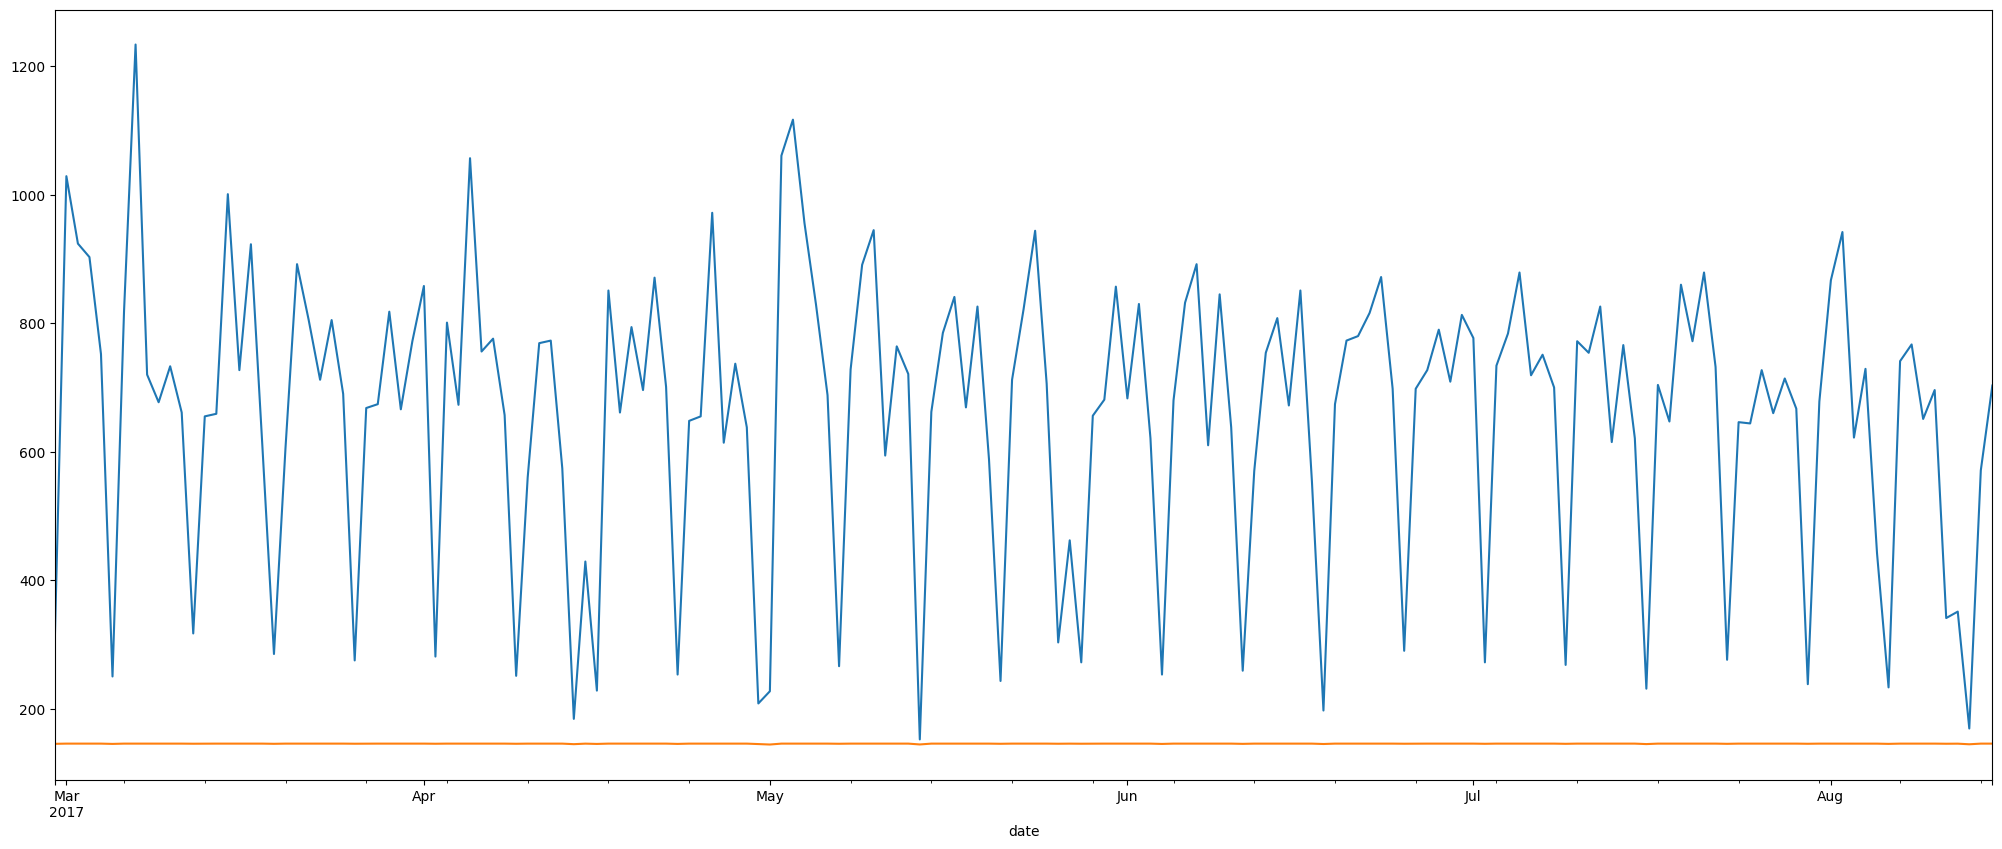

In [11]:
compare('1_CLEANING')

R2 Score: -8.627133108237661
RMSLE: 1.5831599767374152


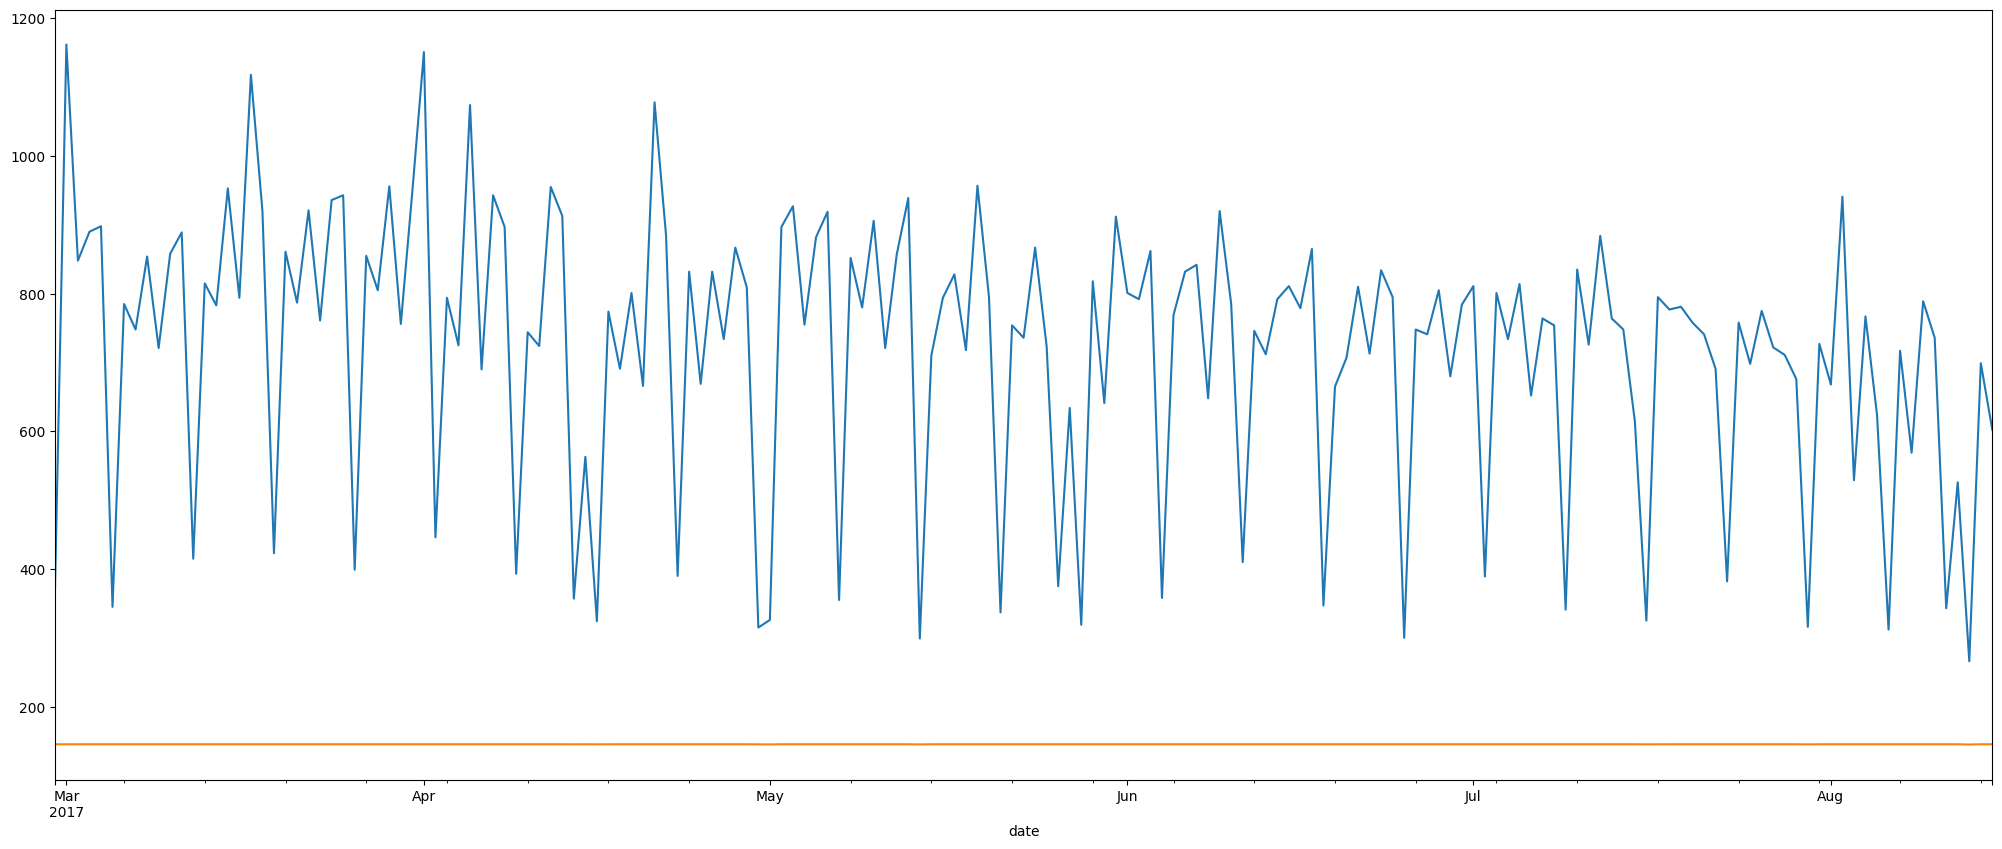

In [12]:
compare('1_DAIRY')

R2 Score: 0.6382852565297539
RMSLE: 0.16070259516148533


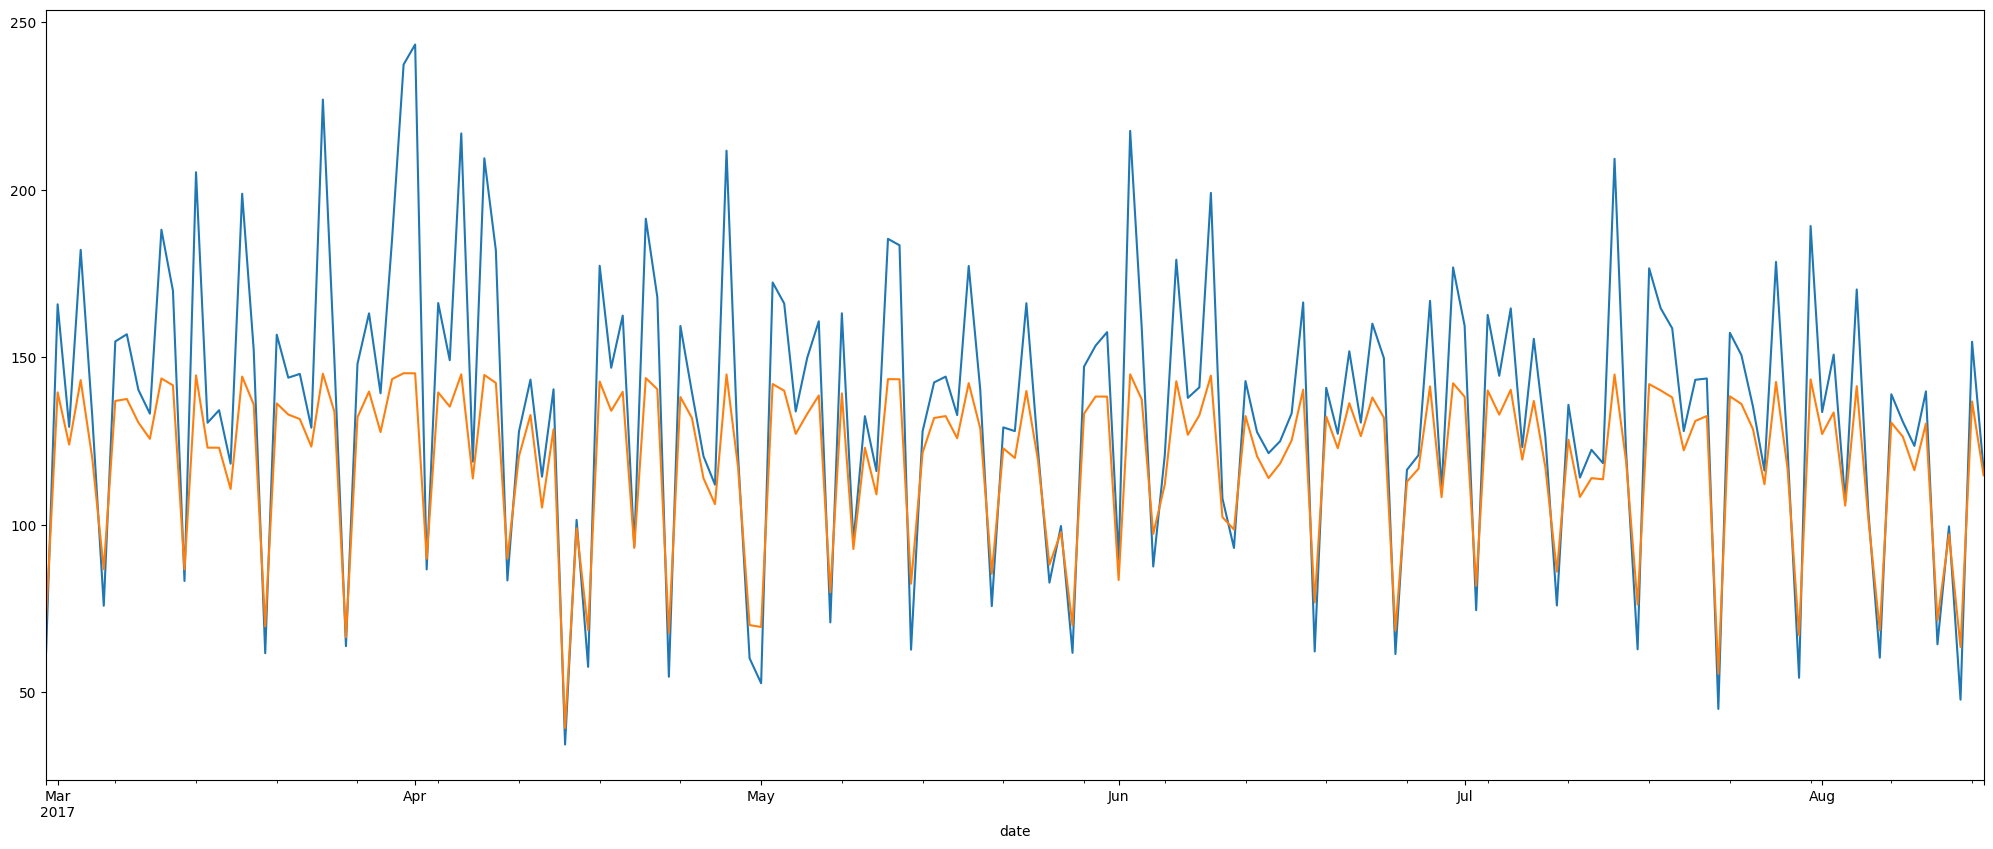

In [13]:
compare('1_DELI')

## RNN Submission

In [14]:
Y = pd.DataFrame()
for feature in train.columns:
    for step in range(1, 17):
        Y[f'{feature}_step_ahead_{step}'] = train[feature].shift(-step, fill_value=0)
Y

1_AUTOMOTIVE_step_ahead_1  1_AUTOMOTIVE_step_ahead_2  \
date                                                               
2013-01-01                        2.0                        3.0   
2013-01-02                        3.0                        3.0   
2013-01-03                        3.0                        5.0   
2013-01-04                        5.0                        2.0   
2013-01-05                        2.0                        0.0   
...                               ...                        ...   
2017-08-11                        6.0                        1.0   
2017-08-12                        1.0                        1.0   
2017-08-13                        1.0                        4.0   
2017-08-14                        4.0                        0.0   
2017-08-15                        0.0                        0.0   

            1_AUTOMOTIVE_step_ahead_3  1_AUTOMOTIVE_step_ahead_4  \
date                                                               
2013-01-01                        3.0                        5.0   
2013-01-02                        5.0                        2.0   
2013-01-03                        2.0                        0.0   
2013-01-04                        0.0                        2.0   
2013-01-05                        2.0                        2.0   
...                               ...                        ...   
2017-08-11                        1.0                        4.0   
2017-08-12                        4.0                        0.0   
2017-08-13                        0.0                        0.0   
2017-08-14                        0.0                        0.0   
2017-08-15                        0.0                        0.0   

            1_AUTOMOTIVE_step_ahead_5  1_AUTOMOTIVE_step_ahead_6  \
date                                                               
2013-01-01                        2.0                        0.0   
2013-01-02                        0.0                        2.0   
2013-01-03                        2.0                        2.0   
2013-01-04                        2.0                        2.0   
2013-01-05                        2.0                        3.0   
...                               ...                        ...   
2017-08-11                        0.0                        0.0   
2017-08-12                        0.0                        0.0   
2017-08-13                        0.0                        0.0   
2017-08-14                        0.0                        0.0   
2017-08-15                        0.0                        0.0   

            1_AUTOMOTIVE_step_ahead_7  1_AUTOMOTIVE_step_ahead_8  \
date                                                               
2013-01-01                        2.0                        2.0   
2013-01-02                        2.0                        2.0   
2013-01-03                        2.0                        3.0   
2013-01-04                        3.0                        2.0   
2013-01-05                        2.0                        2.0   
...                               ...                        ...   
2017-08-11                        0.0                        0.0   
2017-08-12                        0.0                        0.0   
2017-08-13                        0.0                        0.0   
2017-08-14                        0.0                        0.0   
2017-08-15                        0.0                        0.0   

            1_AUTOMOTIVE_step_ahead_9  1_AUTOMOTIVE_step_ahead_10  ...  \
date                                                               ...   
2013-01-01                        2.0                         3.0  ...   
2013-01-02                        3.0                         2.0  ...   
2013-01-03                        2.0                         2.0  ...   
2013-01-04                        2.0                         2.0  ...   
2013-01-05                  

In [15]:
X = train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], 1782, 16)
y_test = y_test.values.reshape(y_test.shape[0], 1782, 16)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1515, 1782, 1)
(169, 1782, 1)
(1515, 1782, 16)
(169, 1782, 16)


In [16]:
rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(16)
])
rnn.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
rnn.summary()
rnn.fit(X_train, y_train, epochs=10, callbacks=[es])
pred_rnn = abs(rnn.predict(X_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 1782, 100)         10200     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 1782, 100)         20100     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 1782, 100)         20100     
                                                                 
 dense_1 (Dense)             (None, 1782, 16)          1616      
                                                                 
Total params: 52,016
Trainable params: 52,016
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 101s 2s/step - loss: 9.2796
Epoch 2/10
48/48 [==============================] - 100s 2s/step - loss: 6.6270
Epoch 3/10
48/48 [====

In [17]:
pred = pd.DataFrame(pred_rnn[168].T, columns=X.columns, index=test.index.unique())
pred

1_AUTOMOTIVE  1_BABY CARE  1_BEAUTY  1_BEVERAGES   1_BOOKS  \
date                                                                     
2017-08-16     23.949478     0.022025  7.393007    27.649307  0.673258   
2017-08-17     19.295212     0.026506  6.803996    22.200602  0.355693   
2017-08-18     21.430401     0.229292  6.738622    24.445606  0.514172   
2017-08-19     18.581877     0.218938  6.324275    21.047060  0.354120   
2017-08-20     18.890495     0.310463  6.675079    21.766695  0.137582   
2017-08-21     20.780497     0.186507  6.861948    23.691765  0.421166   
2017-08-22     21.377169     0.154998  6.655513    24.632399  0.074882   
2017-08-23     20.797230     0.101878  6.567644    23.615328  0.335259   
2017-08-24     23.578846     0.028079  6.771803    27.144262  0.418664   
2017-08-25     25.083580     0.067626  7.384261    28.623186  0.341177   
2017-08-26     20.504059     0.398807  6.600473    23.510883  0.252403   
2017-08-27     22.045122     0.151161  6.905224    25.233114  0.223098   
2017-08-28     21.483761     0.245121  6.856928    24.526951  0.092332   
2017-08-29     20.025923     0.396626  6.587940    22.987391  0.041215   
2017-08-30     16.443417     0.415849  5.873743    18.866152  0.002477   
2017-08-31     21.636234     0.248902  7.081509    24.927048  0.176583   

            1_BREAD_BAKERY  1_CELEBRATION  1_CLEANING    1_DAIRY     1_DELI  \
date                                                                          
2017-08-16       27.631035      18.053852   27.658627  27.654669  27.647505   
2017-08-17       22.186852      15.595874   22.207607  22.203676  22.197880   
2017-08-18       24.430542      16.428757   24.454210  24.450420  24.443502   
2017-08-19       21.032469      14.888548   21.055792  21.050434  21.045206   
2017-08-20       21.751957      14.585492   21.774881  21.771685  21.766172   
2017-08-21       23.677748      16.076199   23.699099  23.694901  23.688744   
2017-08-22       24.621008      16.313671   24.642460  24.639622  24.632710   
2017-08-23       23.600496      16.295732   23.623520  23.622116  23.616800   
2017-08-24       27.126432      18.005552   27.153845  27.149109  27.142305   
2017-08-25       28.609898      18.350702   28.635807  28.628826  28.620049   
2017-08-26       23.493599      15.968250   23.517059  23.512922  23.507076   
2017-08-27       25.219036      16.982216   25.242836  25.239338  25.232441   
2017-08-28       24.511911      16.205921   24.534920  24.530445  24.523022   
2017-08-29       22.969143      15.554706   22.994627  22.991497  22.985544   
2017-08-30       18.854042      13.458851   18.872154  18.868095  18.863333   
2017-08-31       24.910225      16.881485   24.935431  24.931625  24.925198   

            ...  54_MAGAZINES   54_MEATS  54_PERSONAL CARE  54_PET SUPPLIES  \
date        ...                                                               
2017-08-16  ...      1.634592  27.522823         27.646723         0.082327   
2017-08-17  ...      1.763421  22.101582         22.198107         0.043343   
2017-08-18  ...      1.757535  24.337309         24.443840         0.055591   
2017-08-19  ...      1.666489  20.968344         21.046223         0.148875   
2017-08-20  ...      1.452144  21.679188         21.766365         0.320348   
2017-08-21  ...      1.539667  23.595619         23.687412         0.062583   
2017-08-22  ...      1.888462  24.523981         24.633736         0.251560   
2017-08-23  ...      1.649927  23.511299         23.615435         0.106373   
2017-08-24  ...      1.844916  27.026514         27.141310         0.134833   
2017-08-25  ...      1.967862  28.508278         28.619488         0.230258   
2017-08-26  ...      1.815824  23.397209         23.506994         0.299429   
2017-08-27  ...      1.787224  25.121124         25.232147         0.097330   
2017-08-28  ...      1.912032  24.417095         24.523212         0.263454   
2017-08-29  ...      1.639289  22.877701         22.986021         0.24

In [18]:
id = []
sales = []
for i in test.id:
    row = test[test['id'] == i]
    column = f"{row['store_nbr'][0]}_{row['family'][0].replace('/', '_')}"
    value = pred[column][pred.index == row.index[0]][0]
    # The info from the ID row is taken and used to form a variable called column. 
    # This column variable refers to the correct store in the dataframe and the equality check on the indexes refer to the proper dates lining up.
    id.append(i)
    sales.append(value)
rnn_submission = pd.DataFrame({'id': id, 'sales': sales})
rnn_submission

id      sales
0      3000888  23.949478
1      3000889   0.022025
2      3000890   7.393007
3      3000891  27.649307
4      3000892   0.673258
...        ...        ...
28507  3029395  24.916695
28508  3029396  24.920856
28509  3029397  24.935055
28510  3029398  24.915802
28511  3029399  14.912984

[28512 rows x 2 columns]

In [19]:
rnn_submission.to_csv('RNN_submission.csv', header=True, index=False)

# LSTM

In [76]:
X = train
Y = train.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], 1782, 1)
y_test = y_test.values.reshape(y_test.shape[0], 1782, 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1515, 1782, 1)
(169, 1782, 1)
(1515, 1782, 1)
(169, 1782, 1)


In [77]:
lstm = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(1)
])
lstm.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
lstm.summary()
lstm.fit(X_train, y_train, epochs=100, callbacks=[es])
pred_lstm = abs(lstm.predict(X_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1782, 100)         40800     
                                                                 
 lstm_10 (LSTM)              (None, 1782, 100)         80400     
                                                                 
 lstm_11 (LSTM)              (None, 1782, 100)         80400     
                                                                 
 dense_3 (Dense)             (None, 1782, 1)           101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48/48 [==============================] - 10s 154ms/step - loss: 7.8108
Epoch 2/100
48/48 [==============================] - 7s 154ms/step - loss: 6.0832
Epoch 3/100
48/

In [78]:
print(pred_lstm.shape)
pred_lstm

(169, 1782, 1)


array([[[  2.582522  ],
        [  2.1314764 ],
        [  1.9399321 ],
        ...,
        [207.47176   ],
        [  0.37692893],
        [  3.0236475 ]],

       [[  2.7877004 ],
        [  1.3819339 ],
        [  1.8843625 ],
        ...,
        [207.38507   ],
        [  0.30578414],
        [  5.1403003 ]],

       [[  2.2134128 ],
        [  2.254142  ],
        [  3.285276  ],
        ...,
        [207.48044   ],
        [  0.33791128],
        [  4.9348187 ]],

       ...,

       [[  2.7877004 ],
        [  1.3819337 ],
        [  1.8867683 ],
        ...,
        [207.60928   ],
        [  0.54812586],
        [  3.7451606 ]],

       [[  2.7877004 ],
        [  1.3819337 ],
        [  2.702798  ],
        ...,
        [207.50081   ],
        [  0.3904437 ],
        [  1.2229224 ]],

       [[  2.1134858 ],
        [  2.28778   ],
        [  2.3875632 ],
        ...,
        [207.53777   ],
        [  0.5798196 ],
        [  3.8977358 ]]], dtype=float32)

In [79]:
pred_lstm = pred_lstm.reshape(169, 1782)
pred = pd.DataFrame(pred_lstm, columns=X.columns, index=X_test_index)
pred

1_AUTOMOTIVE  1_BABY CARE  1_BEAUTY  1_BEVERAGES   1_BOOKS  \
date                                                                     
2017-02-28      2.582522     2.131476  1.939932   198.126144  0.092819   
2017-03-01      2.787700     1.381934  1.884362   194.823578  0.123839   
2017-03-02      2.213413     2.254142  3.285276   199.437805  0.167142   
2017-03-03      2.229027     2.308906  3.482050   200.159866  0.168737   
2017-03-04      2.494184     2.329269  2.583443   200.185654  0.616222   
...                  ...          ...       ...          ...       ...   
2017-08-11      2.787700     1.381934  1.886768   194.426529  0.018147   
2017-08-12      2.494184     2.329268  2.100993   200.115417  0.166647   
2017-08-13      2.787700     1.381934  1.886768   194.395920  0.010262   
2017-08-14      2.787700     1.381934  2.702798   195.133041  0.168882   
2017-08-15      2.113486     2.287780  2.387563   199.777588  0.174099   

            1_BREAD_BAKERY  1_CELEBRATION  1_CLEANING     1_DAIRY      1_DELI  \
date                                                                            
2017-02-28      165.630112       7.599608  205.014587  207.269455   81.228973   
2017-03-01      204.563156      17.521860  206.667297  207.573746  140.294952   
2017-03-02      204.787445      20.461952  207.111801  207.640701   99.148331   
2017-03-03      204.862183      20.769609  207.139465  207.645889  161.970566   
2017-03-04      205.060806       9.146463  205.627701  207.405045  107.972687   
...                    ...            ...         ...         ...         ...   
2017-08-11      180.490662       7.173443  205.195602  207.276810   86.048111   
2017-08-12      204.122787       6.513539  205.312119  207.359985  106.396309   
2017-08-13      174.546982       4.333703  190.697861  206.401154   68.135063   
2017-08-14      204.411163       7.506027  205.459702  207.375198  147.344086   
2017-08-15      204.739365      17.625364  206.758514  207.579529  100.593689   

            ...  54_MAGAZINES    54_MEATS  54_PERSONAL CARE  54_PET SUPPLIES  \
date        ...                                                                
2017-02-28  ...      0.470339   67.672386        200.432800         0.315477   
2017-03-01  ...      1.141055   73.397743        205.633026         1.237218   
2017-03-02  ...      0.996006   77.053253        205.059219         0.445680   
2017-03-03  ...      1.143655   84.031044        205.570892         0.382996   
2017-03-04  ...      1.188764   67.985649        205.383392         0.399876   
...         ...           ...         ...               ...              ...   
2017-08-11  ...      0.497465   70.269257        195.508240         0.438760   
2017-08-12  ...      1.365690   70.367149        199.998611         0.556585   
2017-08-13  ...      2.409593  115.878265        206.653534         1.030056   
2017-08-14  ...      1.229003  100.307266        205.340256         0.738085   
2017-08-15  ...      2.934209   65.540848        200.752274         0.717381   

            54_PLAYERS AND ELECTRONICS  54_POULTRY  54_PREPARED FOODS  \
date                                                                    
2017-02-28                    5.561654   82.232697          61.018955   
2017-03-01                    3.028190   73.325722          59.161762   
2017-03-02                    3.319388   90.197197          59.014973   
2017-03-03                    3.771183   85.851486          60.699108   
2017-03-04                    3.490149   52.287262          95.056549   
...                                ...         ...                ...   
2017-08-11                    1.721108  107.711823          55.020378   
2017-08-12                    3.794894  120.549866          70.812981   
2017-08-13                    4.089365  112.671967          79.495735   
2017-08-14                    3.192929   79.391739         142.977890   
2017-08-15                    3.536439   82.597290          84.183998   

    

R2 Score: 0.10275078734306176
RMSLE: 0.5230094439532892


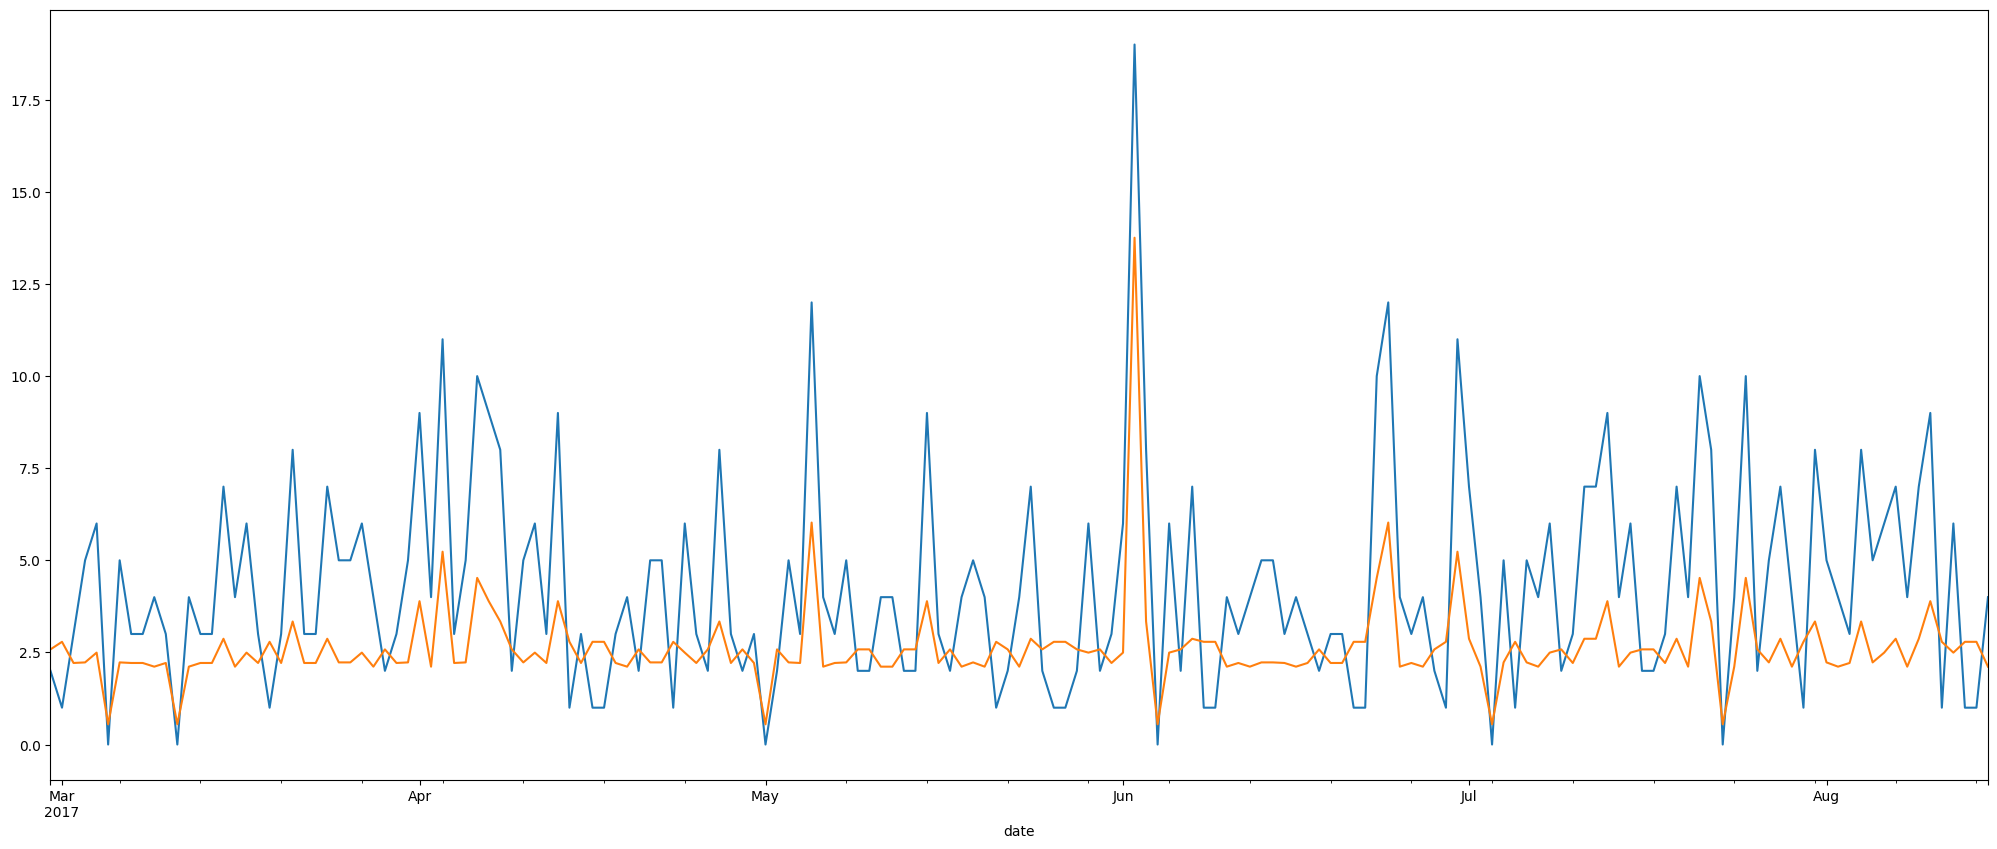

In [80]:
compare('1_AUTOMOTIVE')

R2 Score: 0.0
RMSLE: 1.1378704335155827


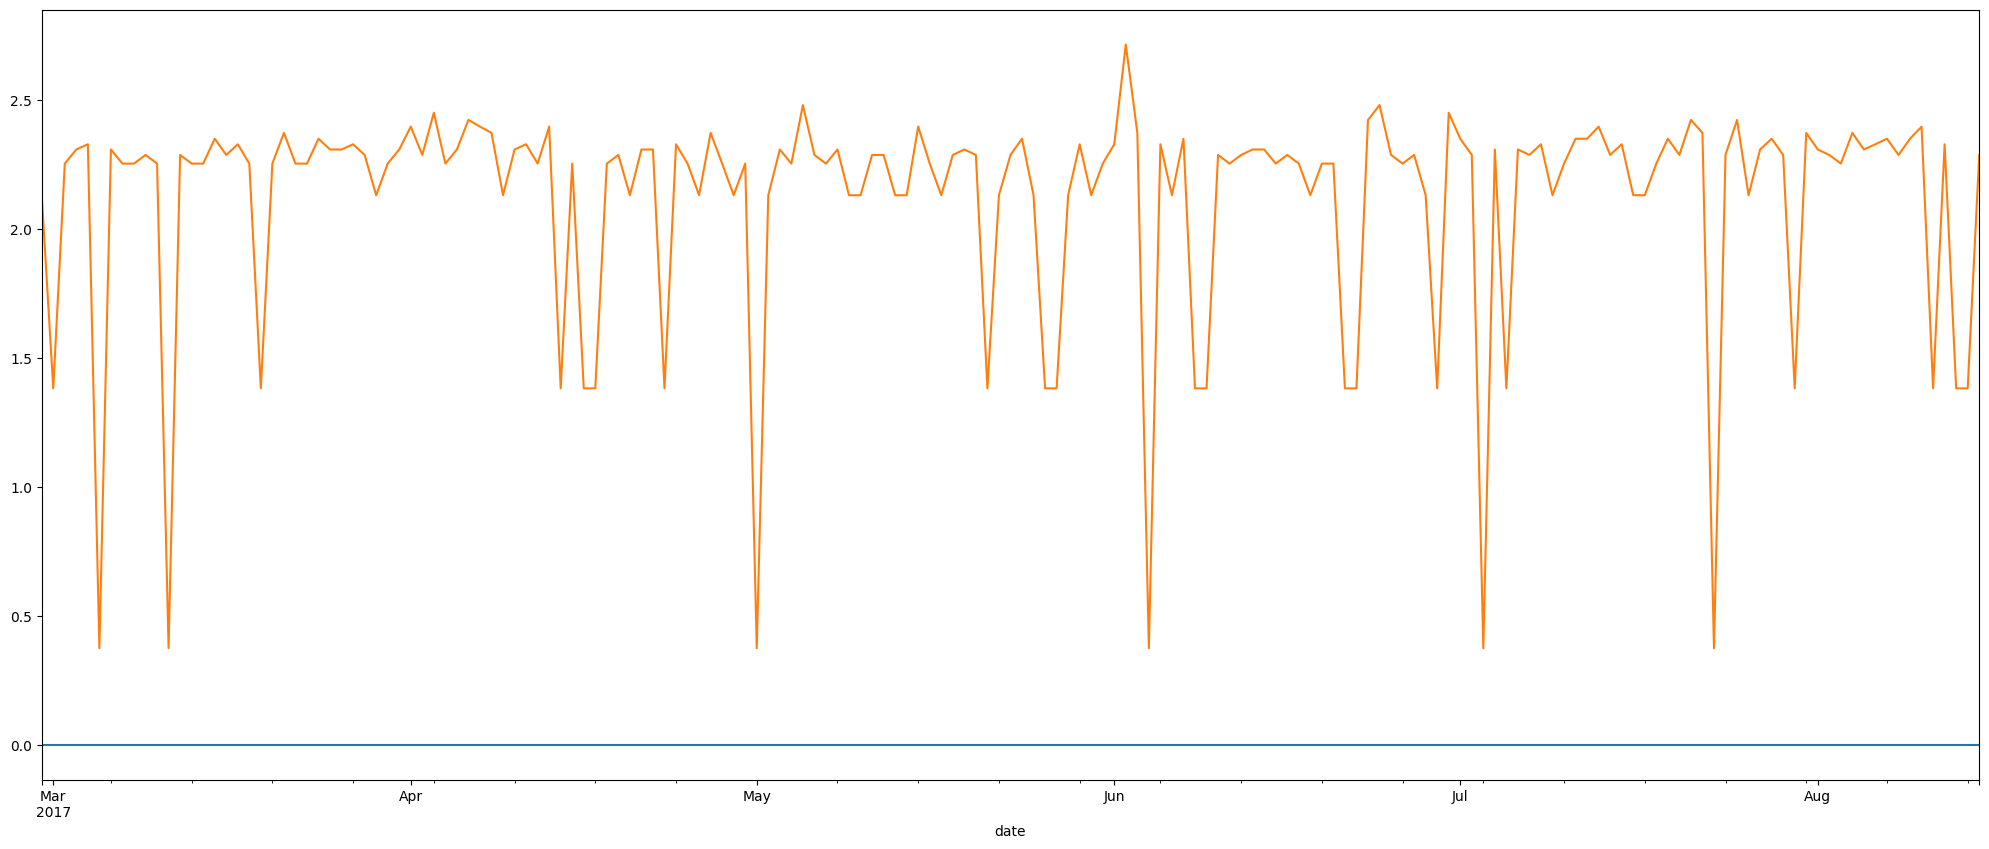

In [81]:
compare('1_BABY CARE')

R2 Score: 0.15805216434336766
RMSLE: 0.4382068657141924


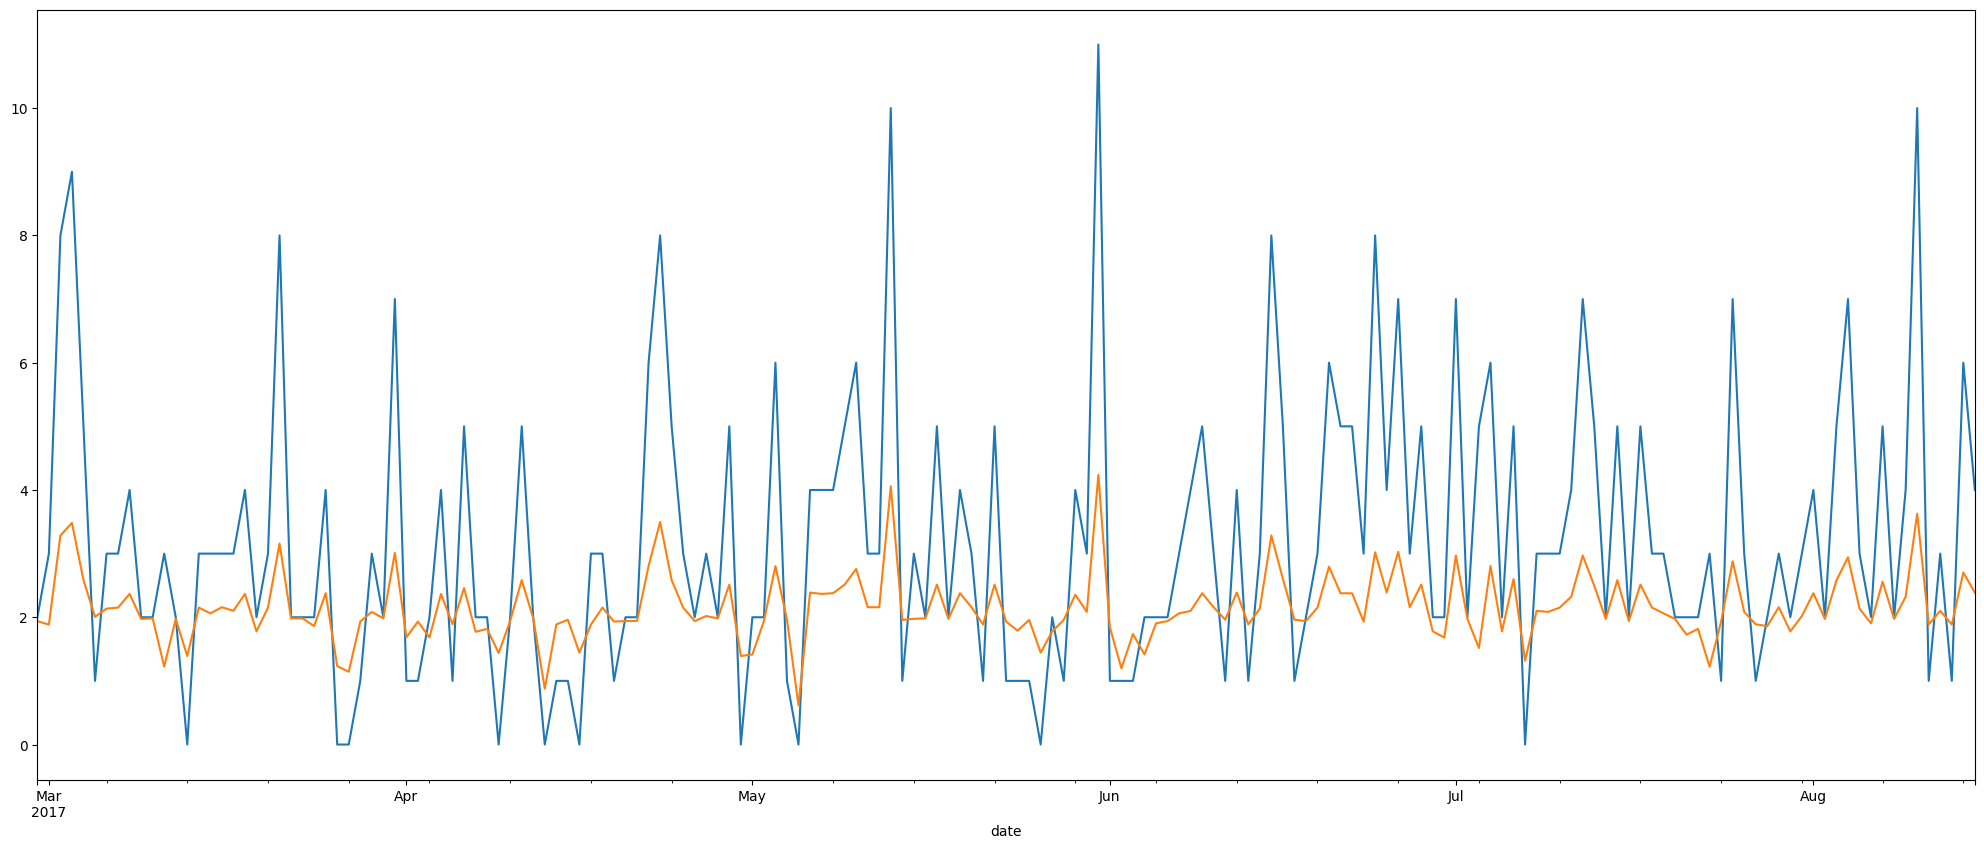

In [82]:
compare('1_BEAUTY')

R2 Score: -11.964877250669424
RMSLE: 2.3633243047916697


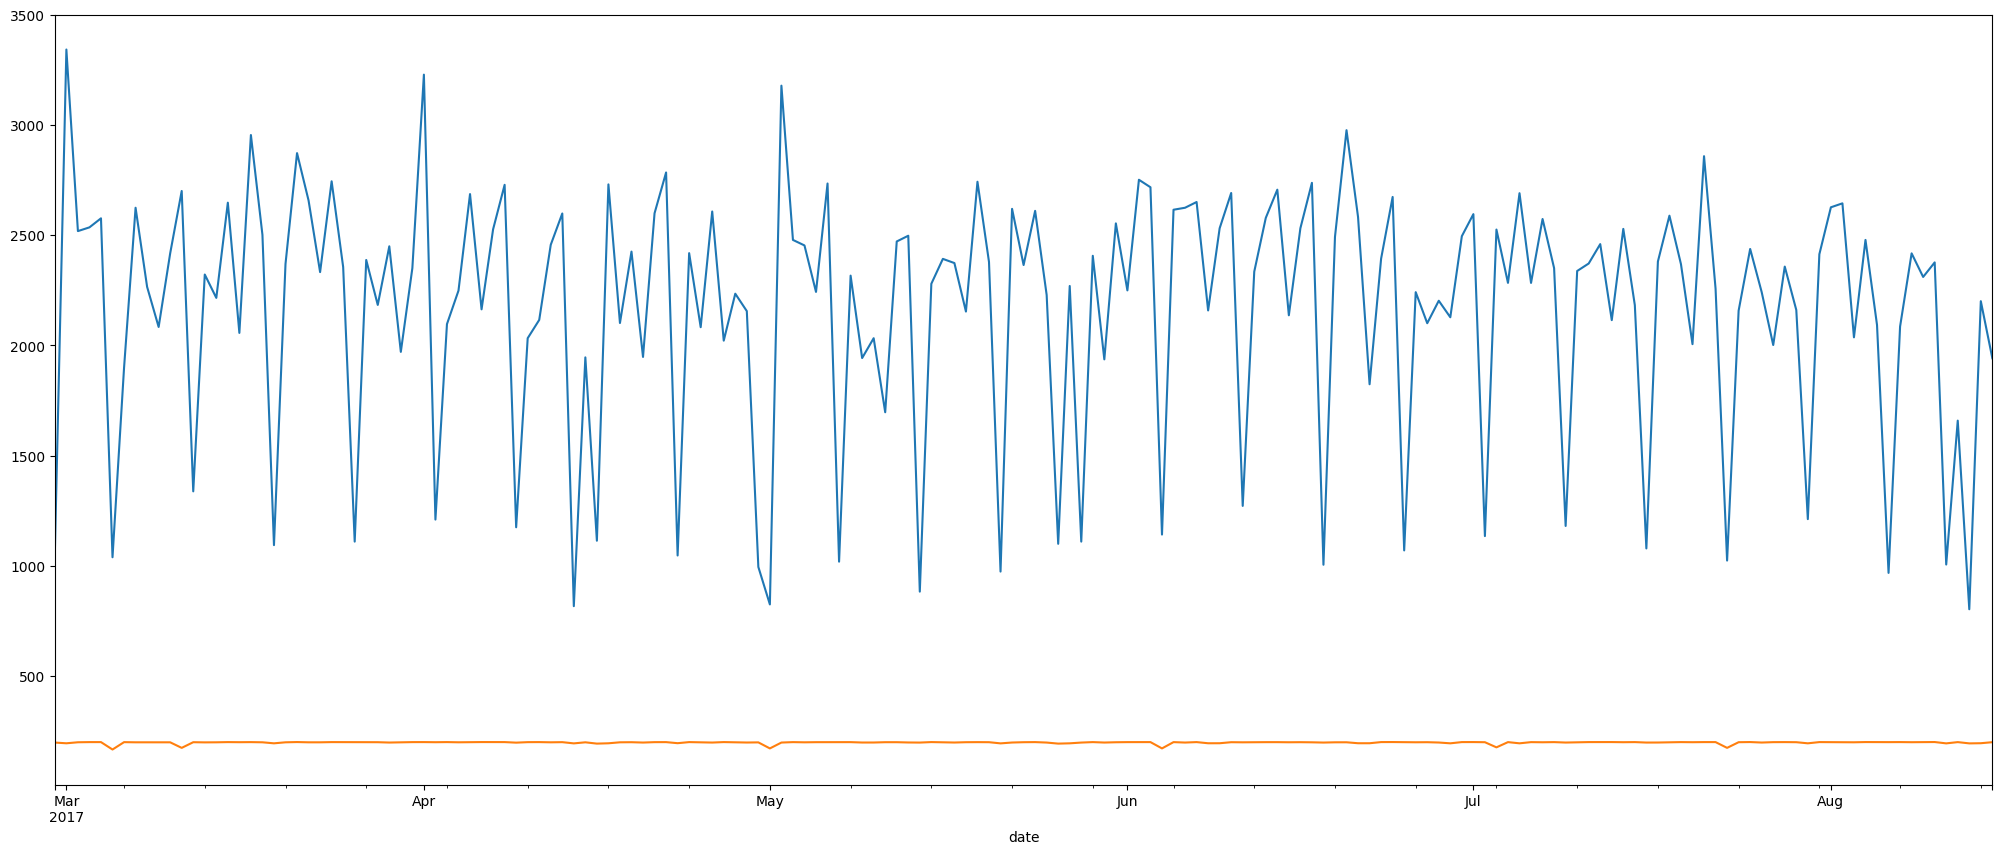

In [83]:
compare('1_BEVERAGES')

R2 Score: 0.8575348471979112
RMSLE: 0.15422624214049596


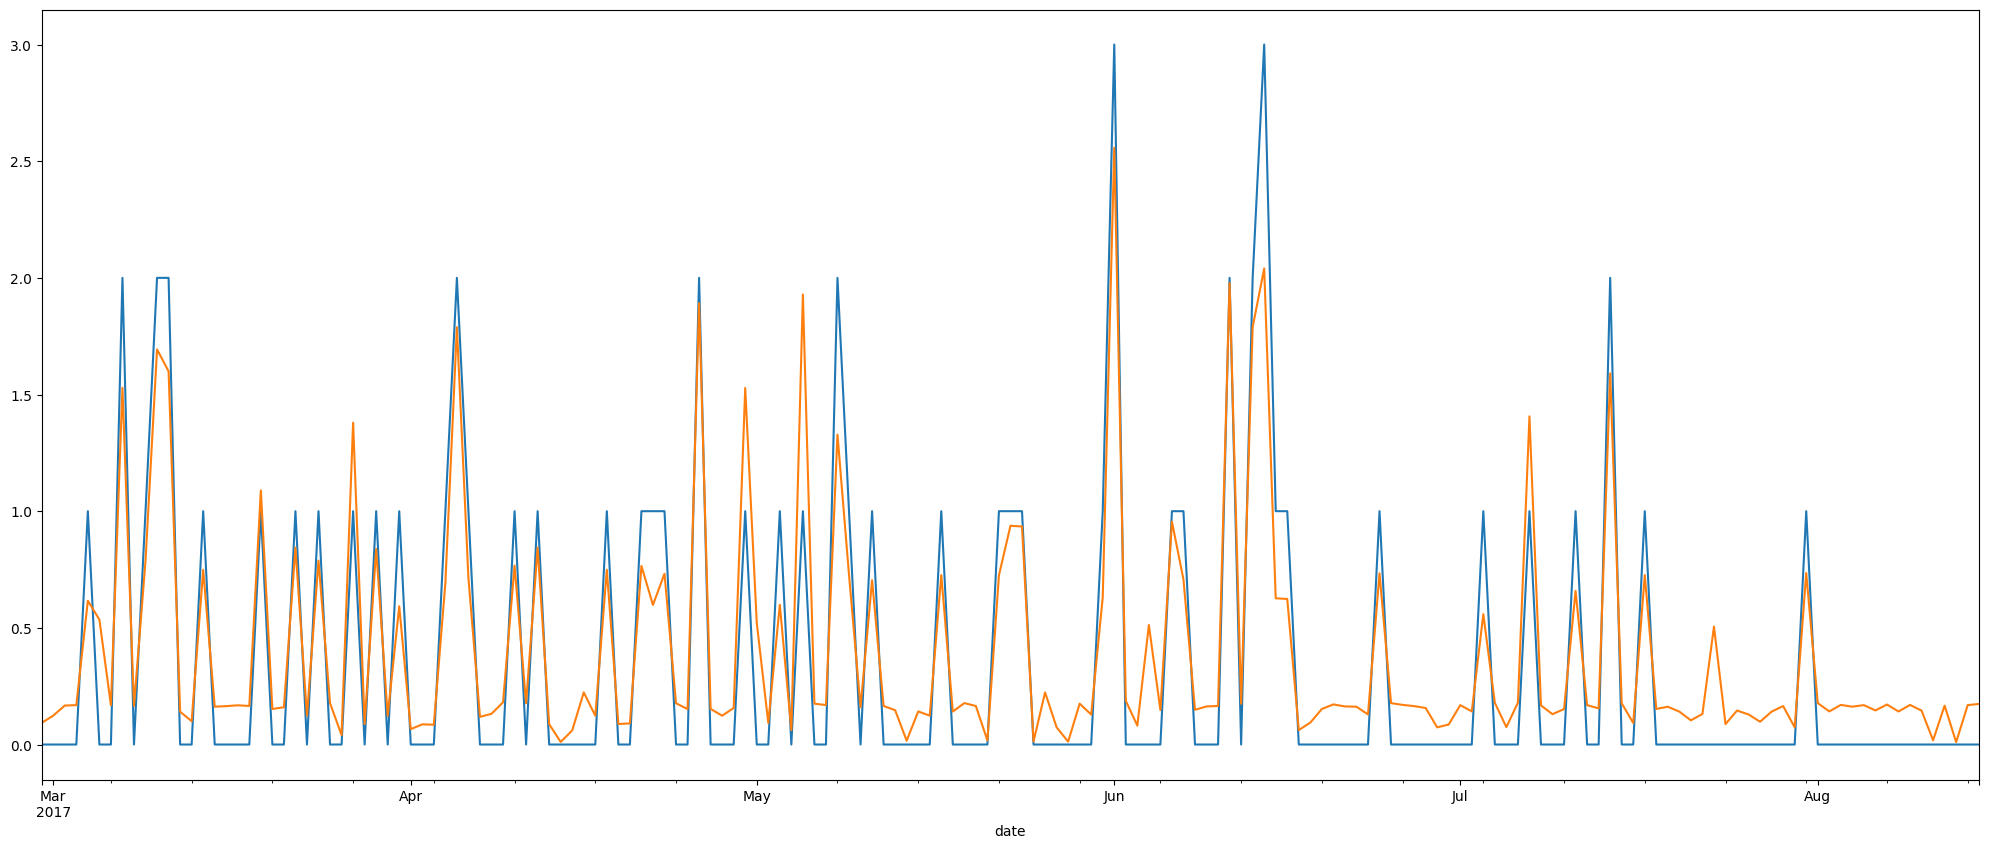

In [84]:
compare('1_BOOKS')

R2 Score: -2.2504239944759767
RMSLE: 0.6124045003837062


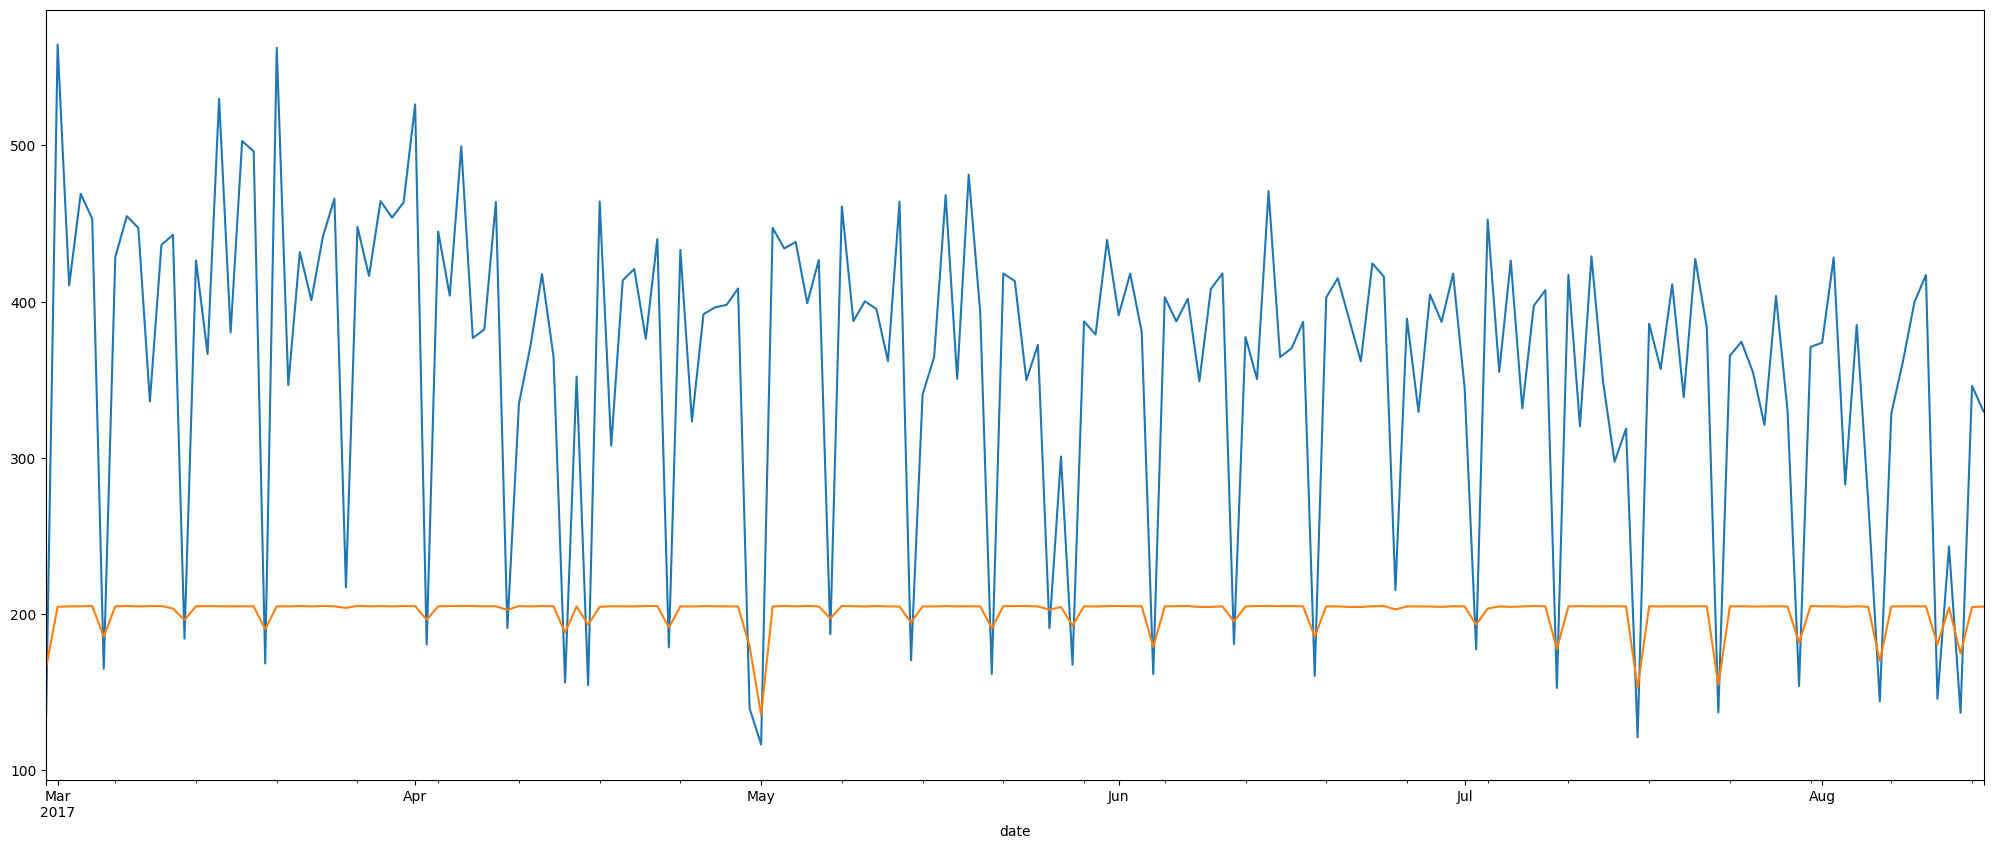

In [85]:
compare('1_BREAD_BAKERY')

R2 Score: 0.883534505822885
RMSLE: 0.2905342206979342


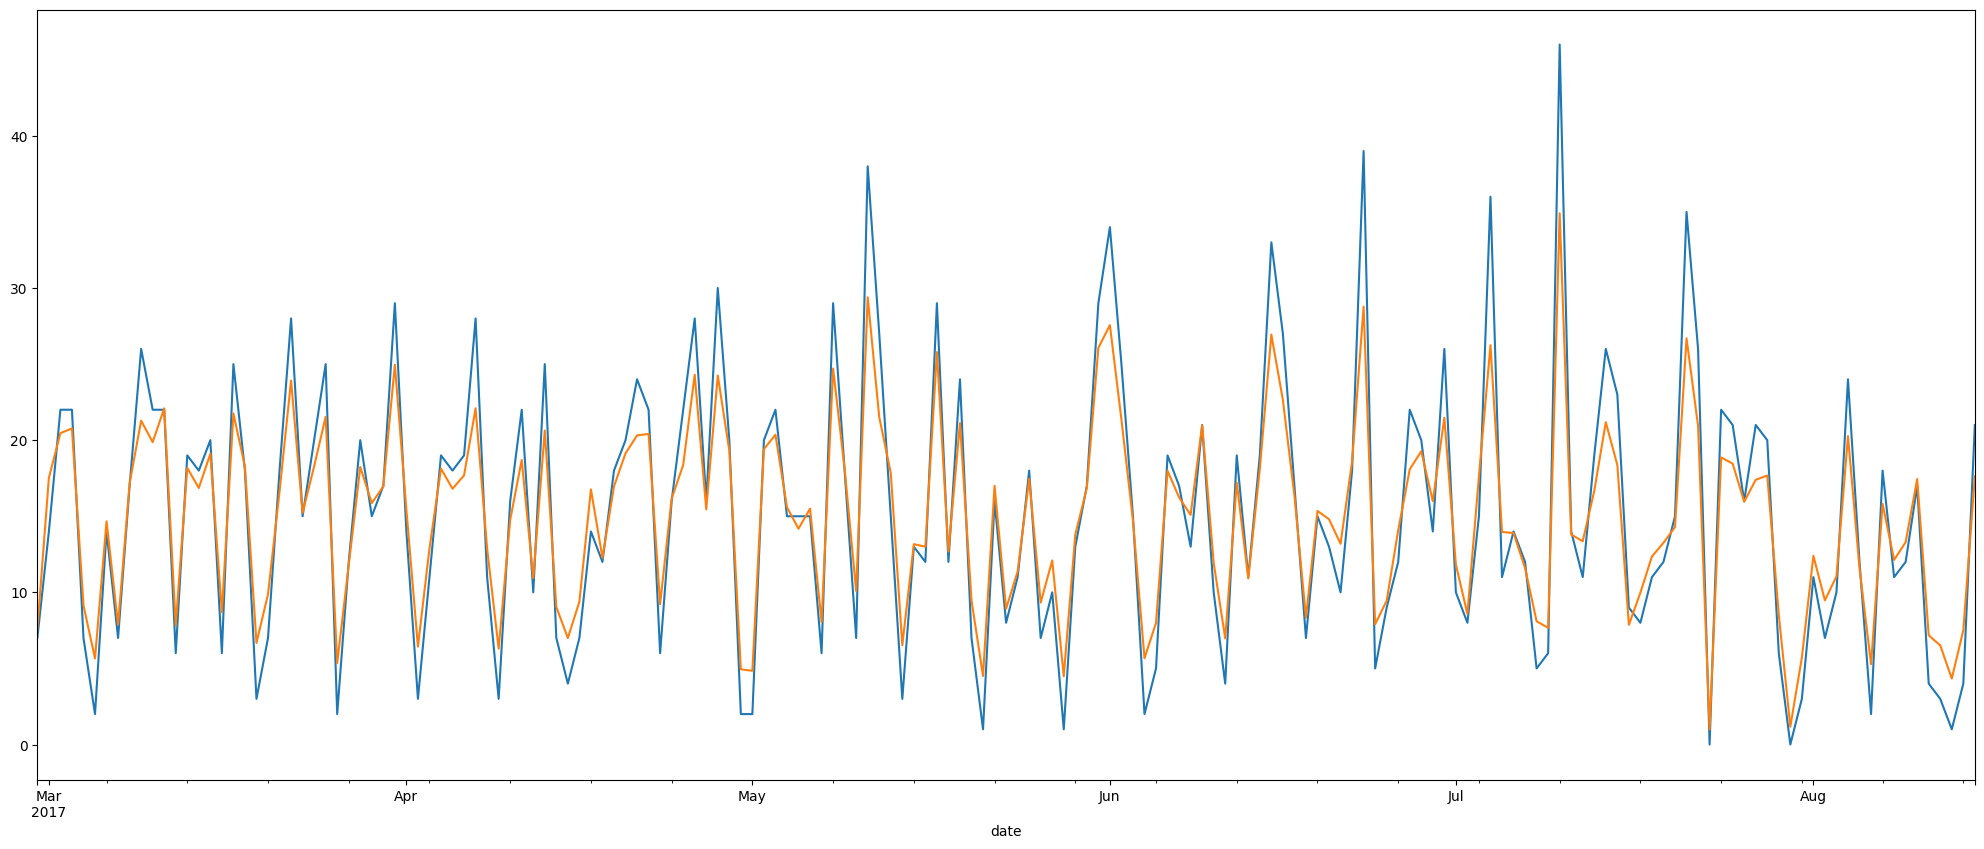

In [86]:
compare('1_CELEBRATION')

R2 Score: -4.238447485603637
RMSLE: 1.1680429566021875


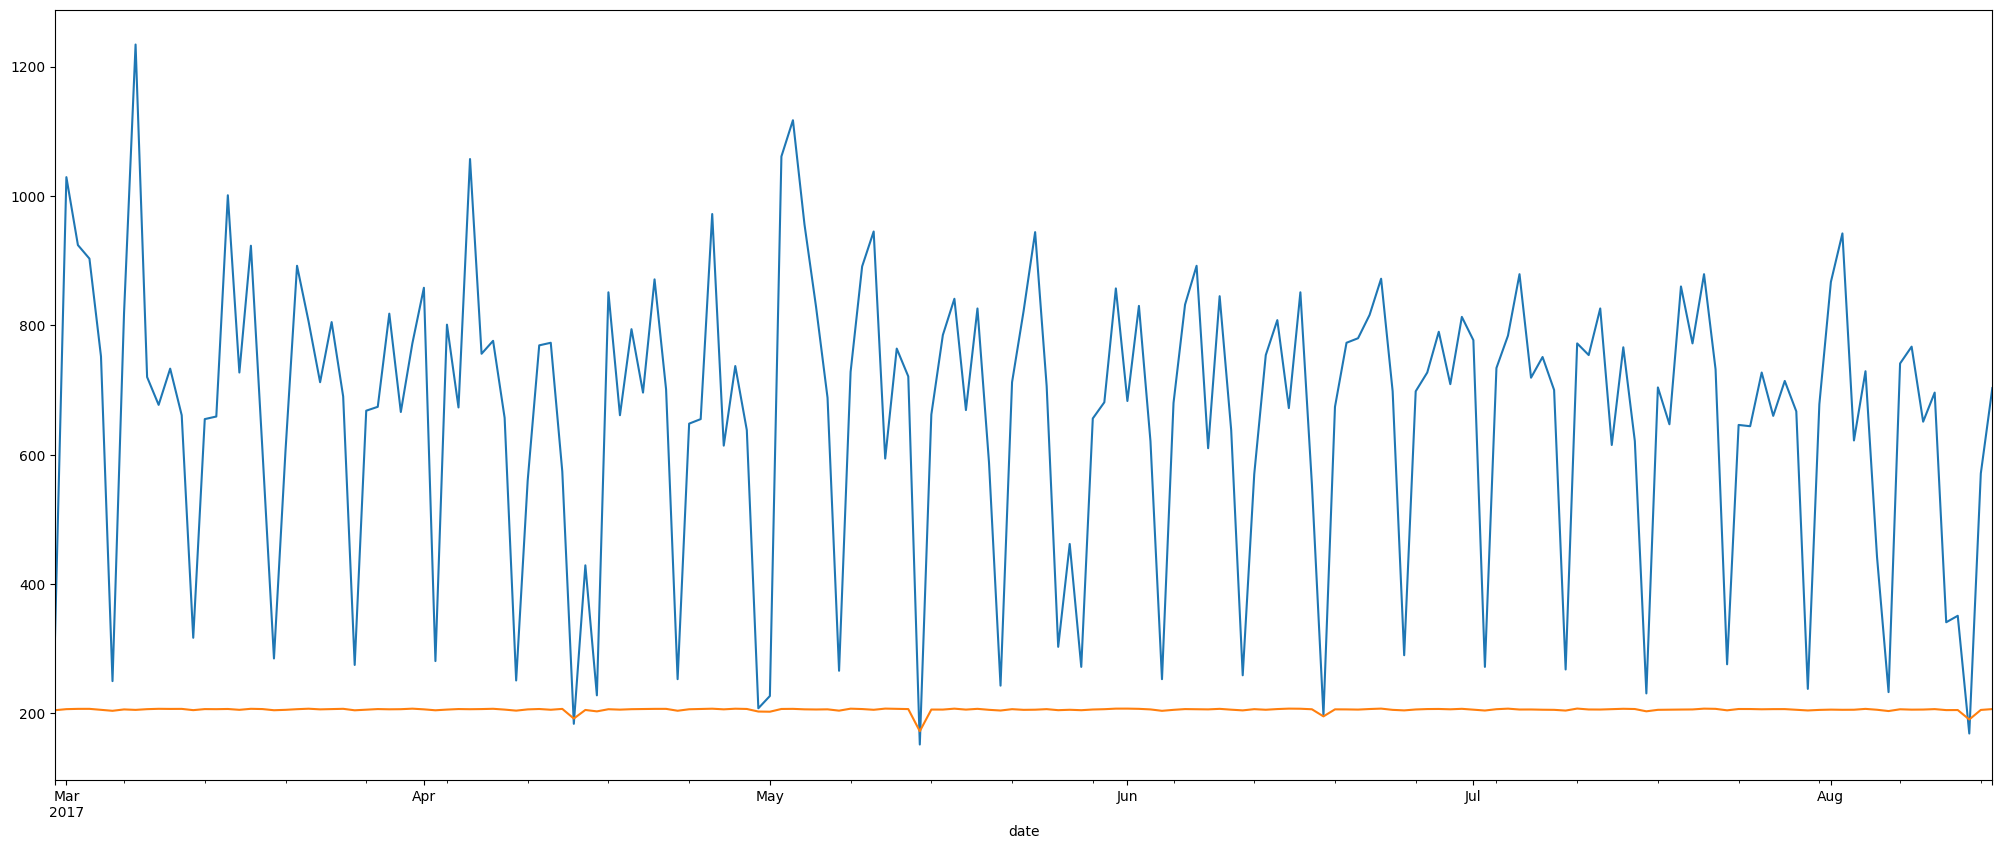

In [87]:
compare('1_CLEANING')

R2 Score: -6.866530456031594
RMSLE: 1.2398130283070397


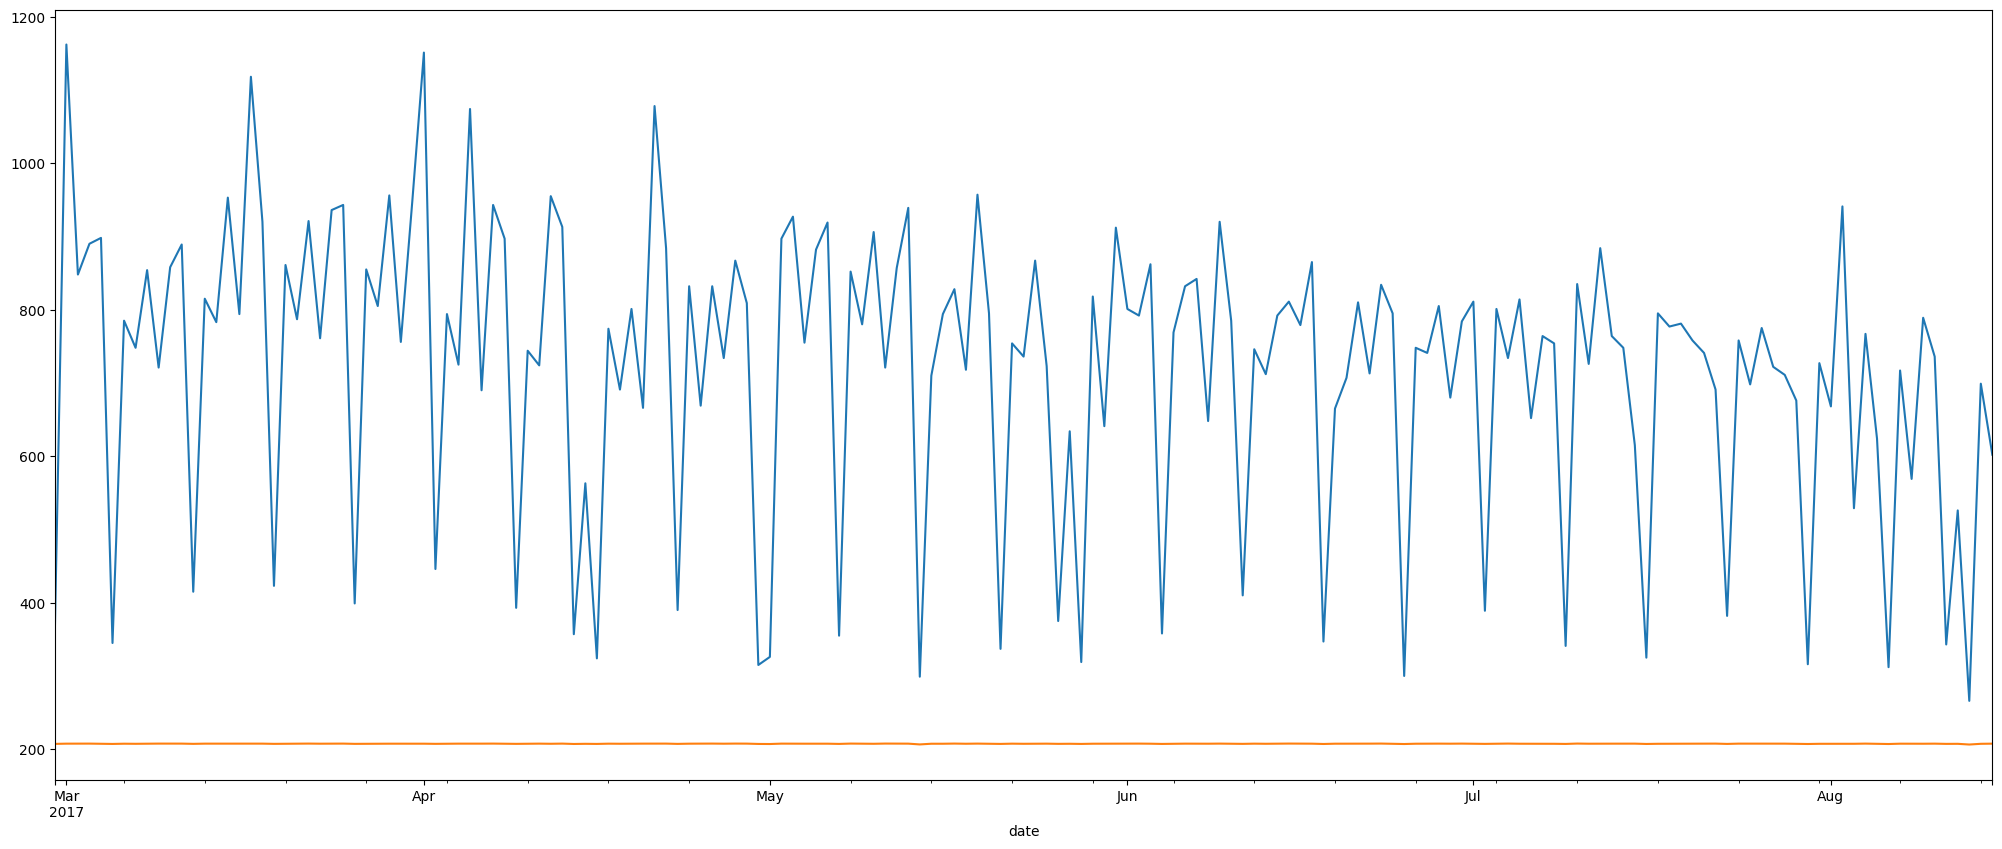

In [88]:
compare('1_DAIRY')

R2 Score: 0.7025786200484984
RMSLE: 0.20131788740542714


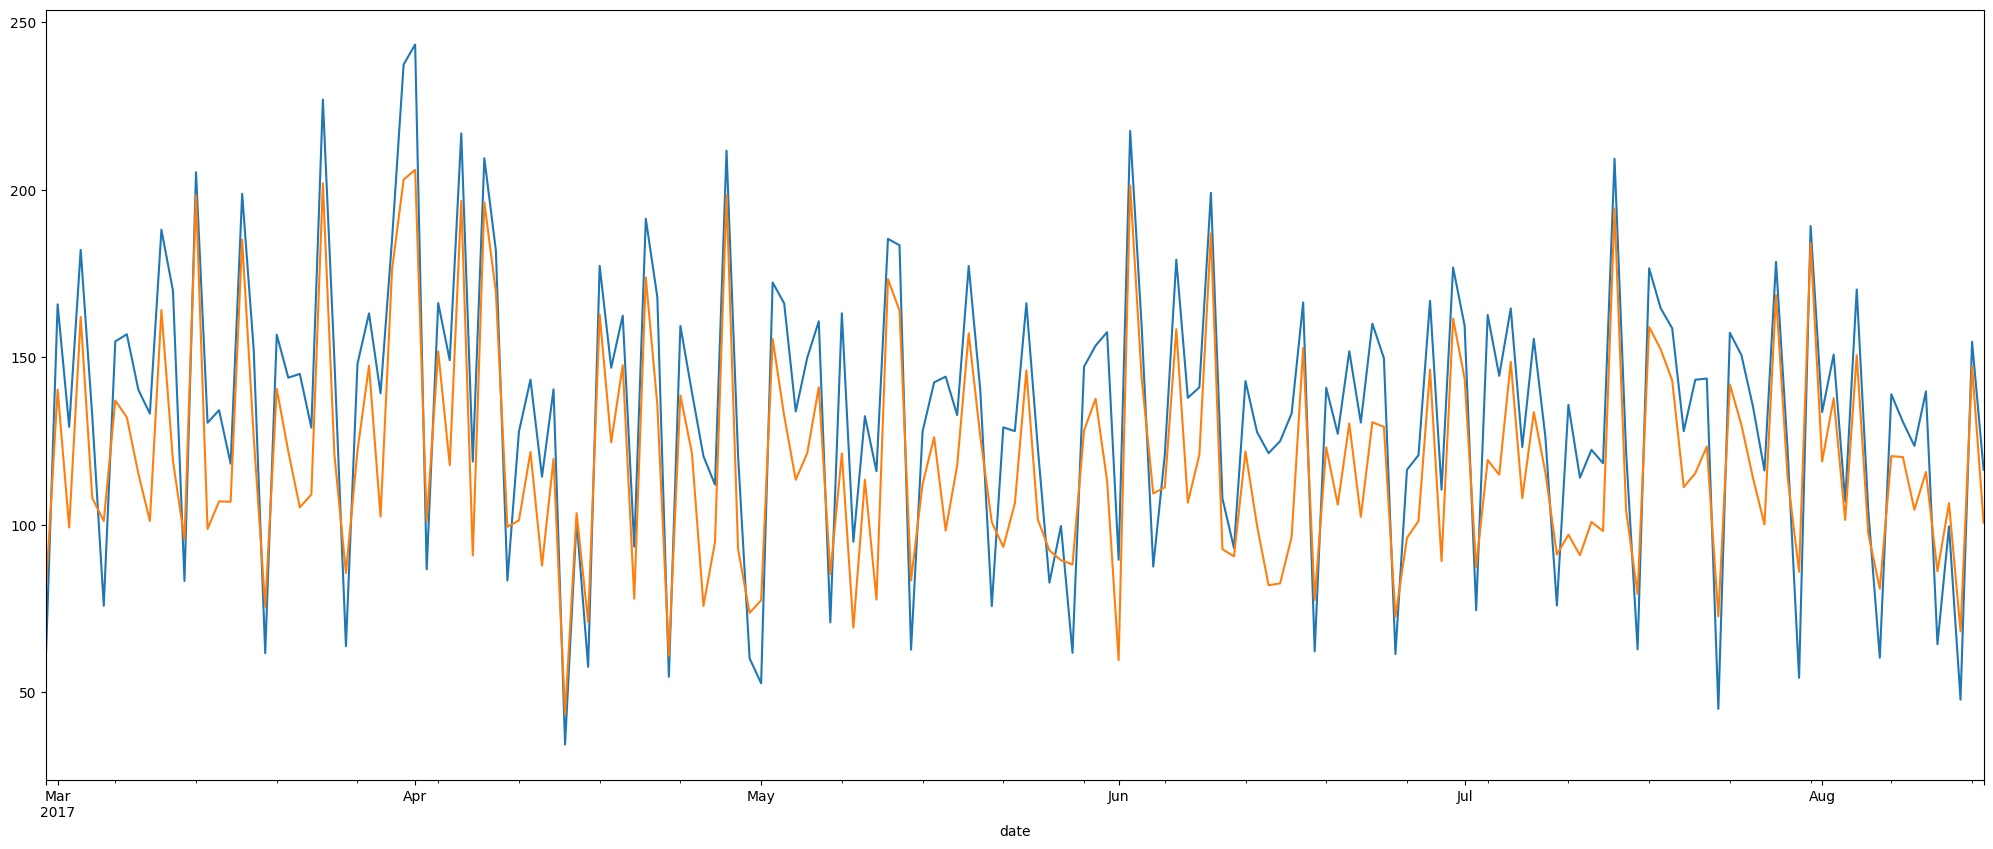

In [89]:
compare('1_DELI')

R2 Score: 0.8093127680511856
RMSLE: 0.1453261715134968


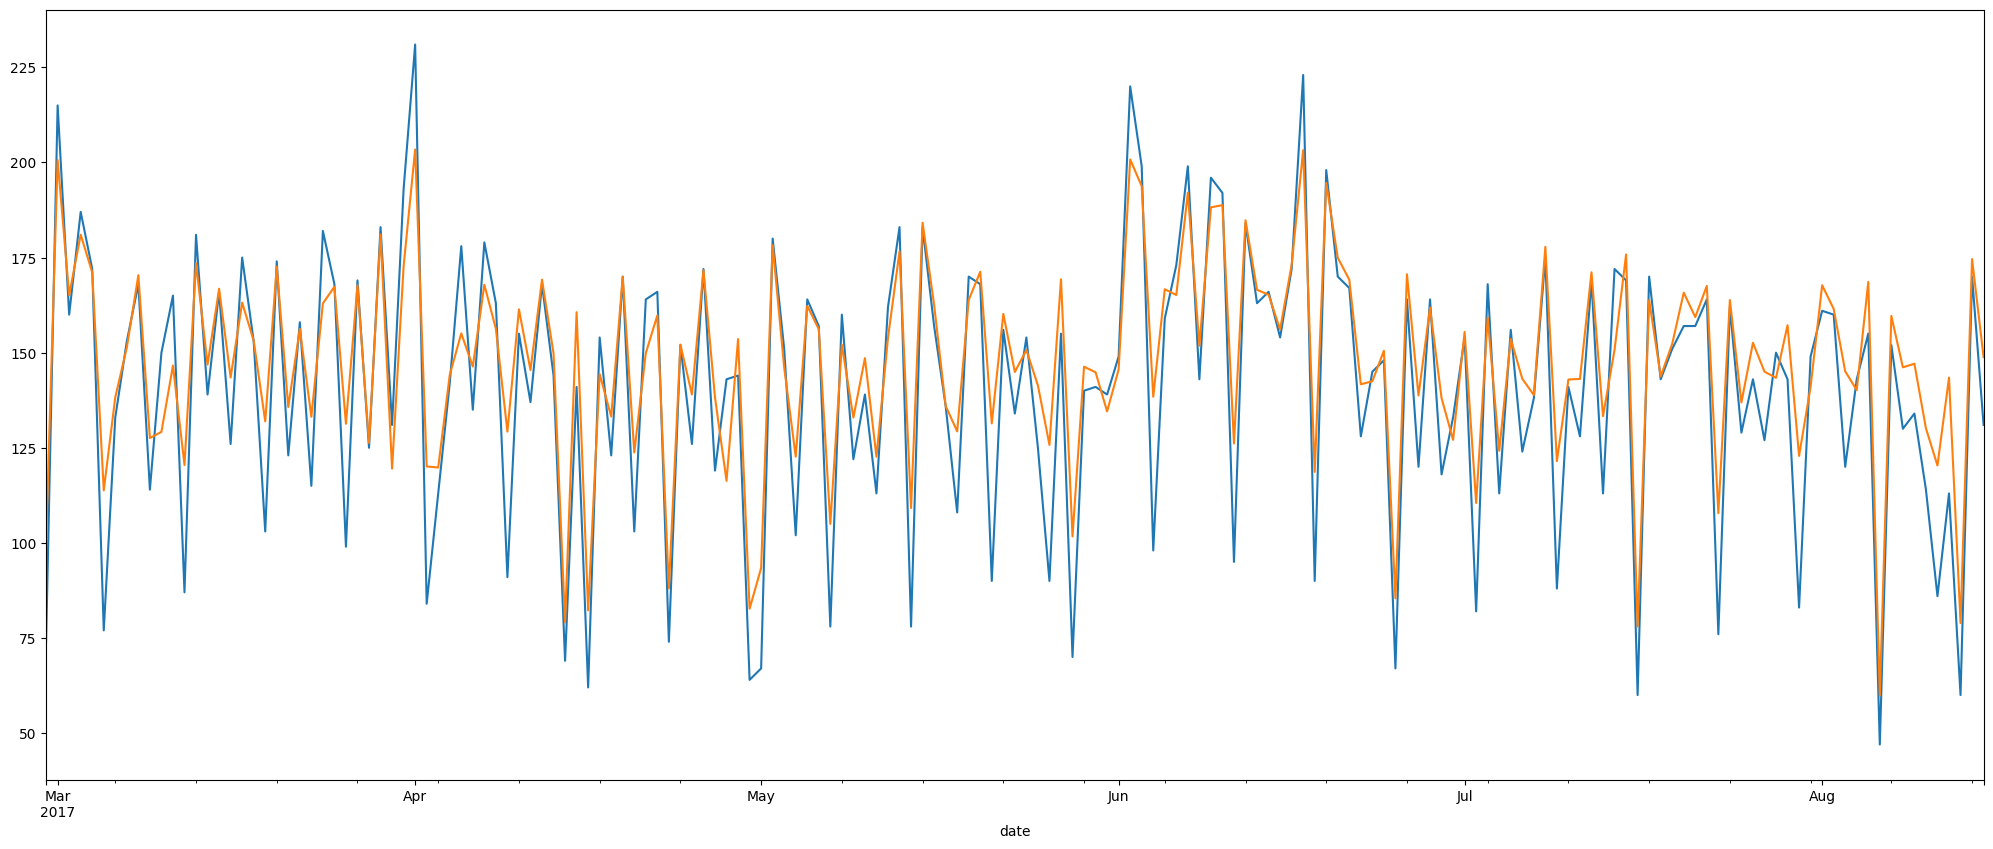

In [90]:
compare('1_EGGS')

R2 Score: 0.8661535481423541
RMSLE: 0.14607808895986113


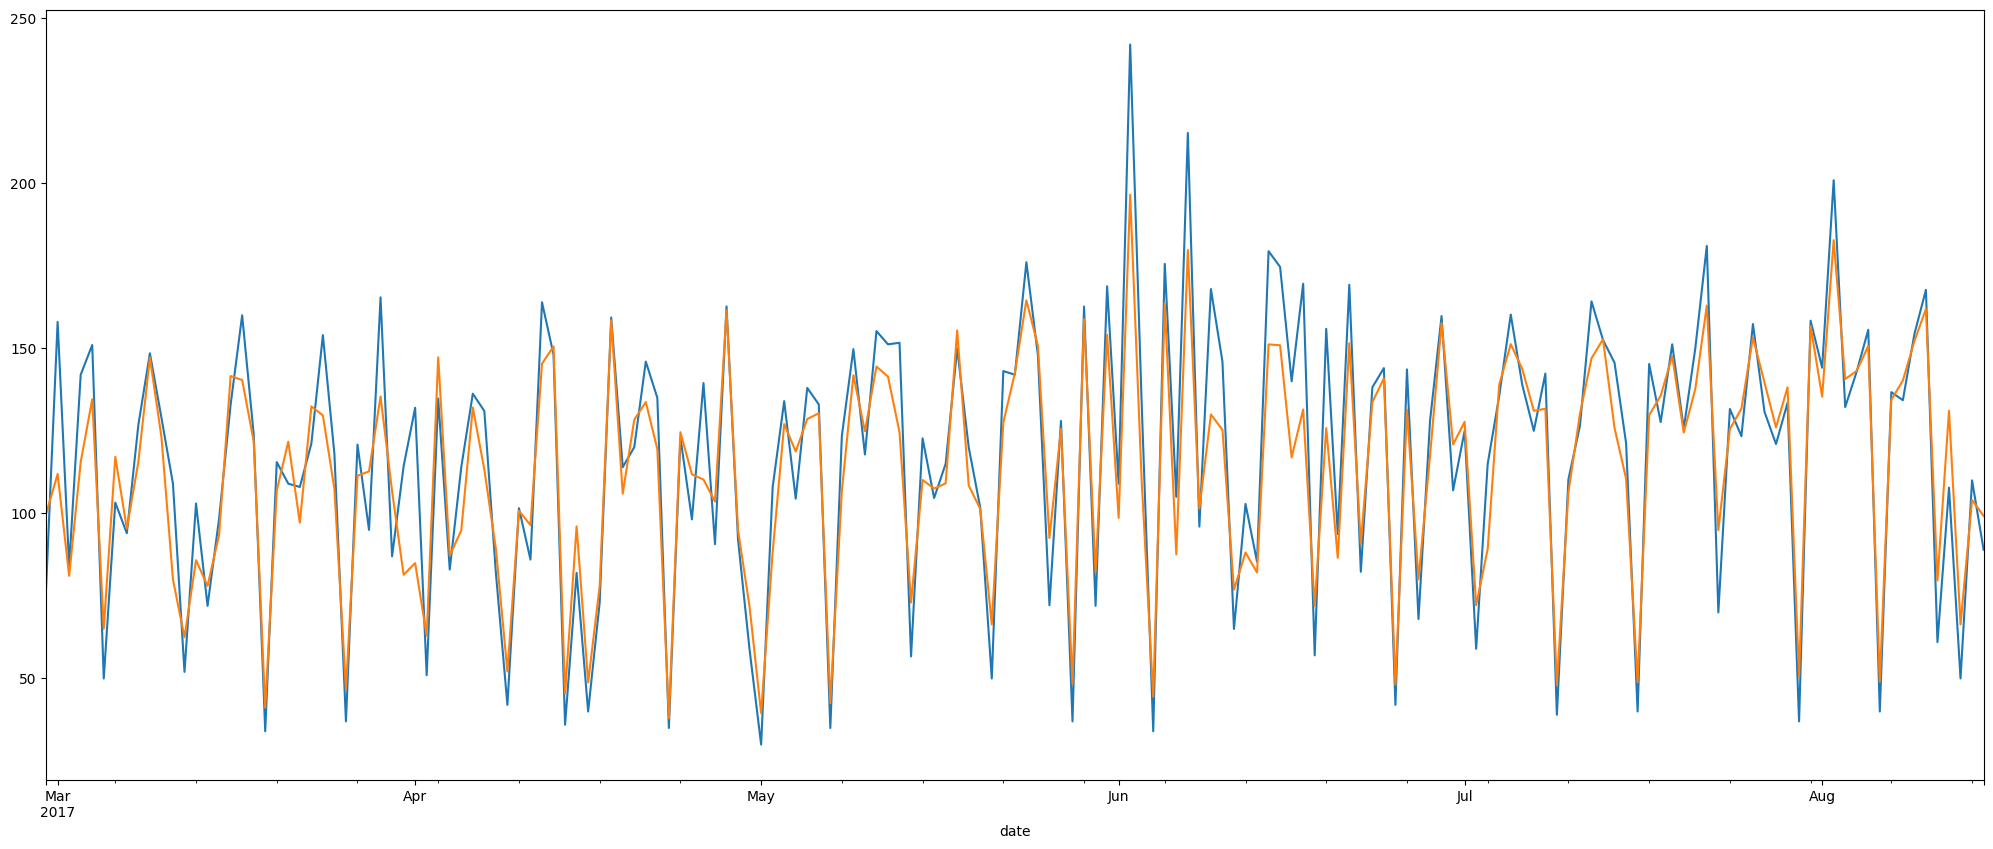

In [91]:
compare('1_FROZEN FOODS')

R2 Score: -9.720836295353969
RMSLE: 2.498897636846807


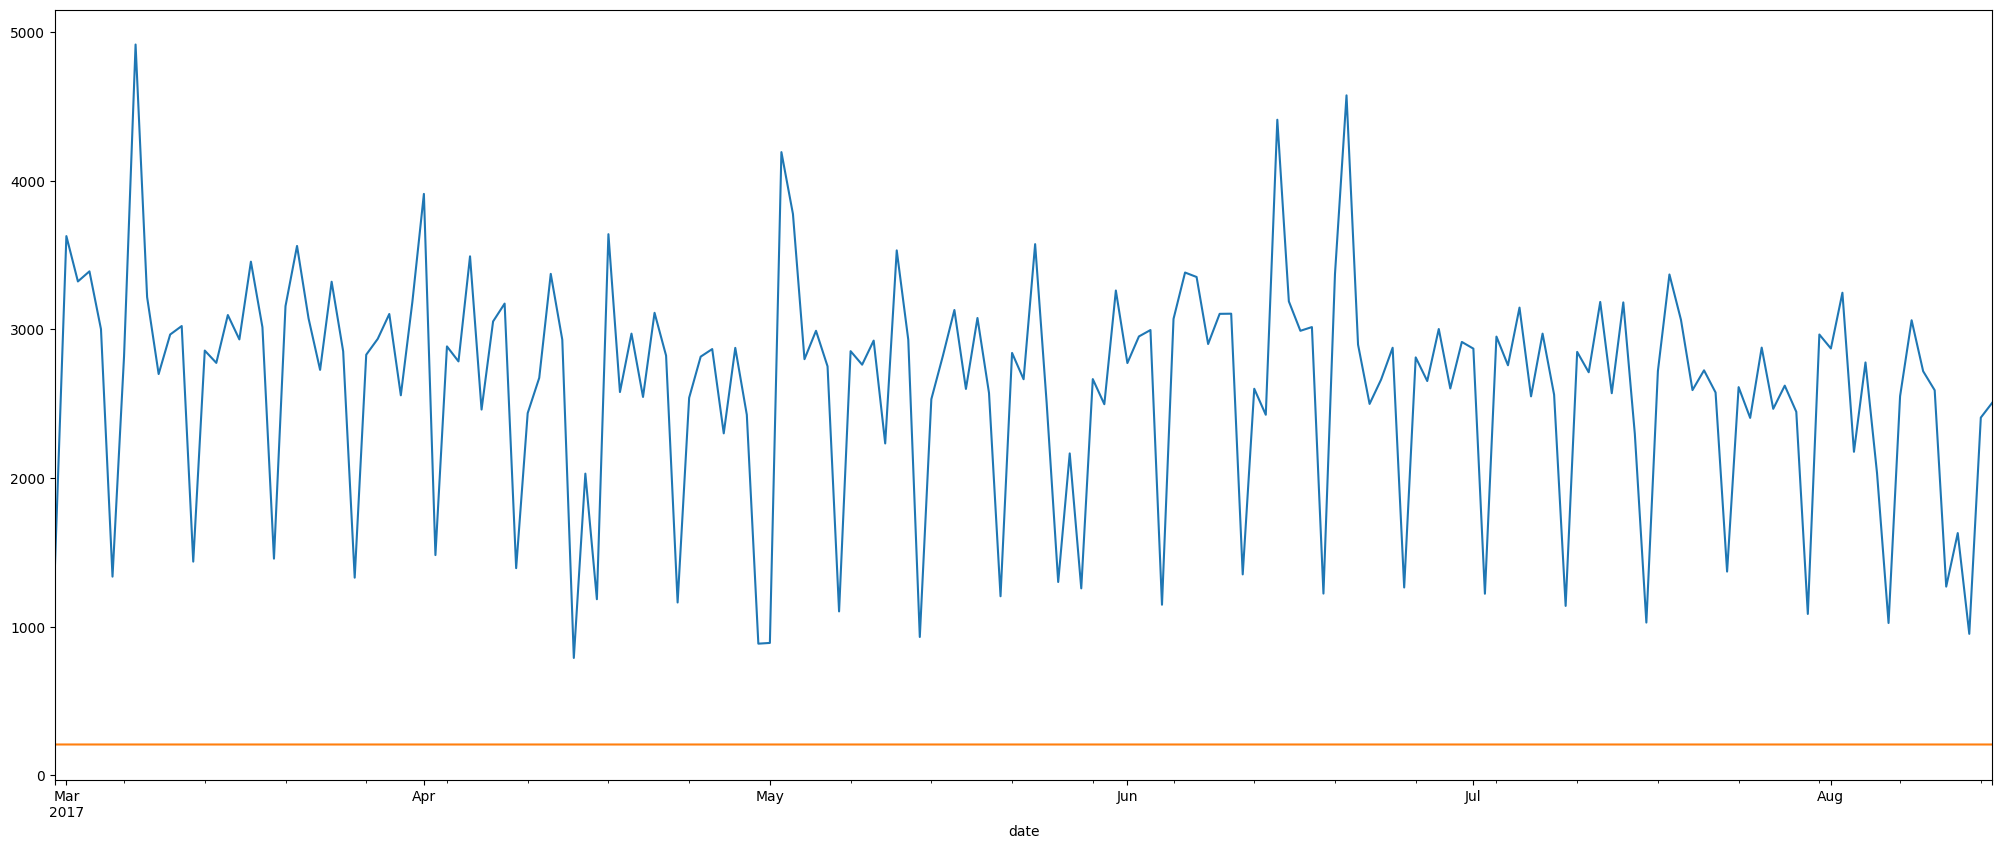

In [92]:
compare('1_GROCERY I')

R2 Score: 0.4314292678221746
RMSLE: 0.36213923888124666


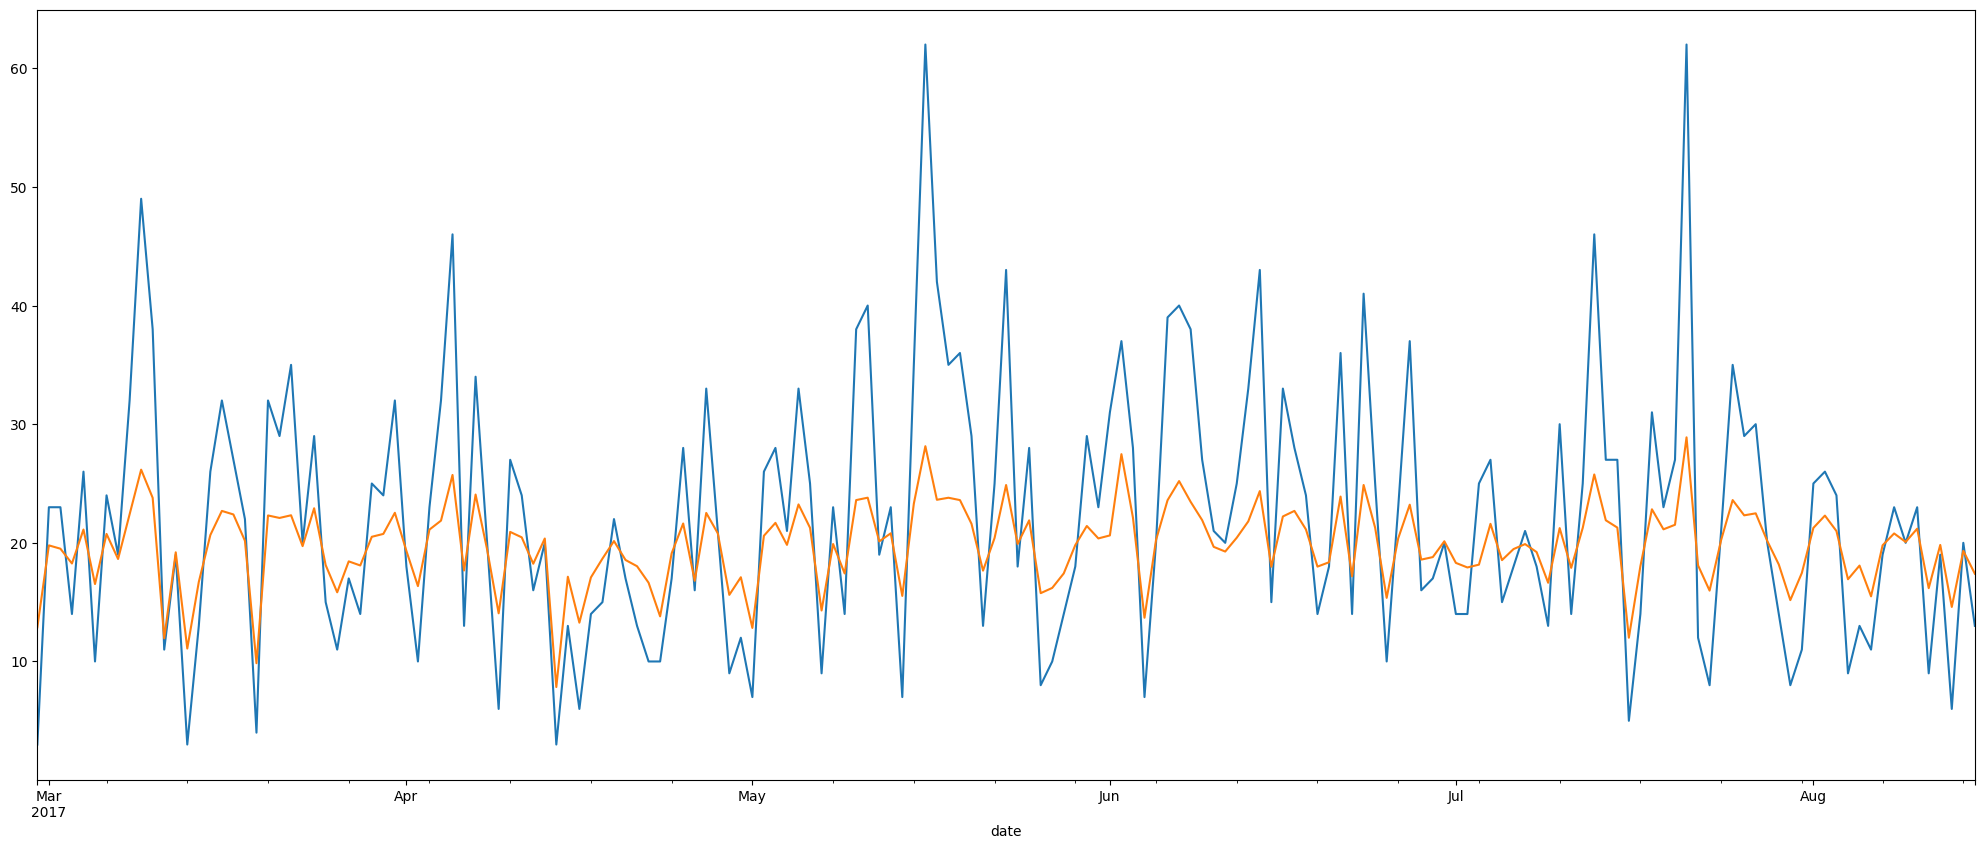

In [93]:
compare('1_GROCERY II')

R2 Score: 0.06838488739400428
RMSLE: 0.5093940206081692


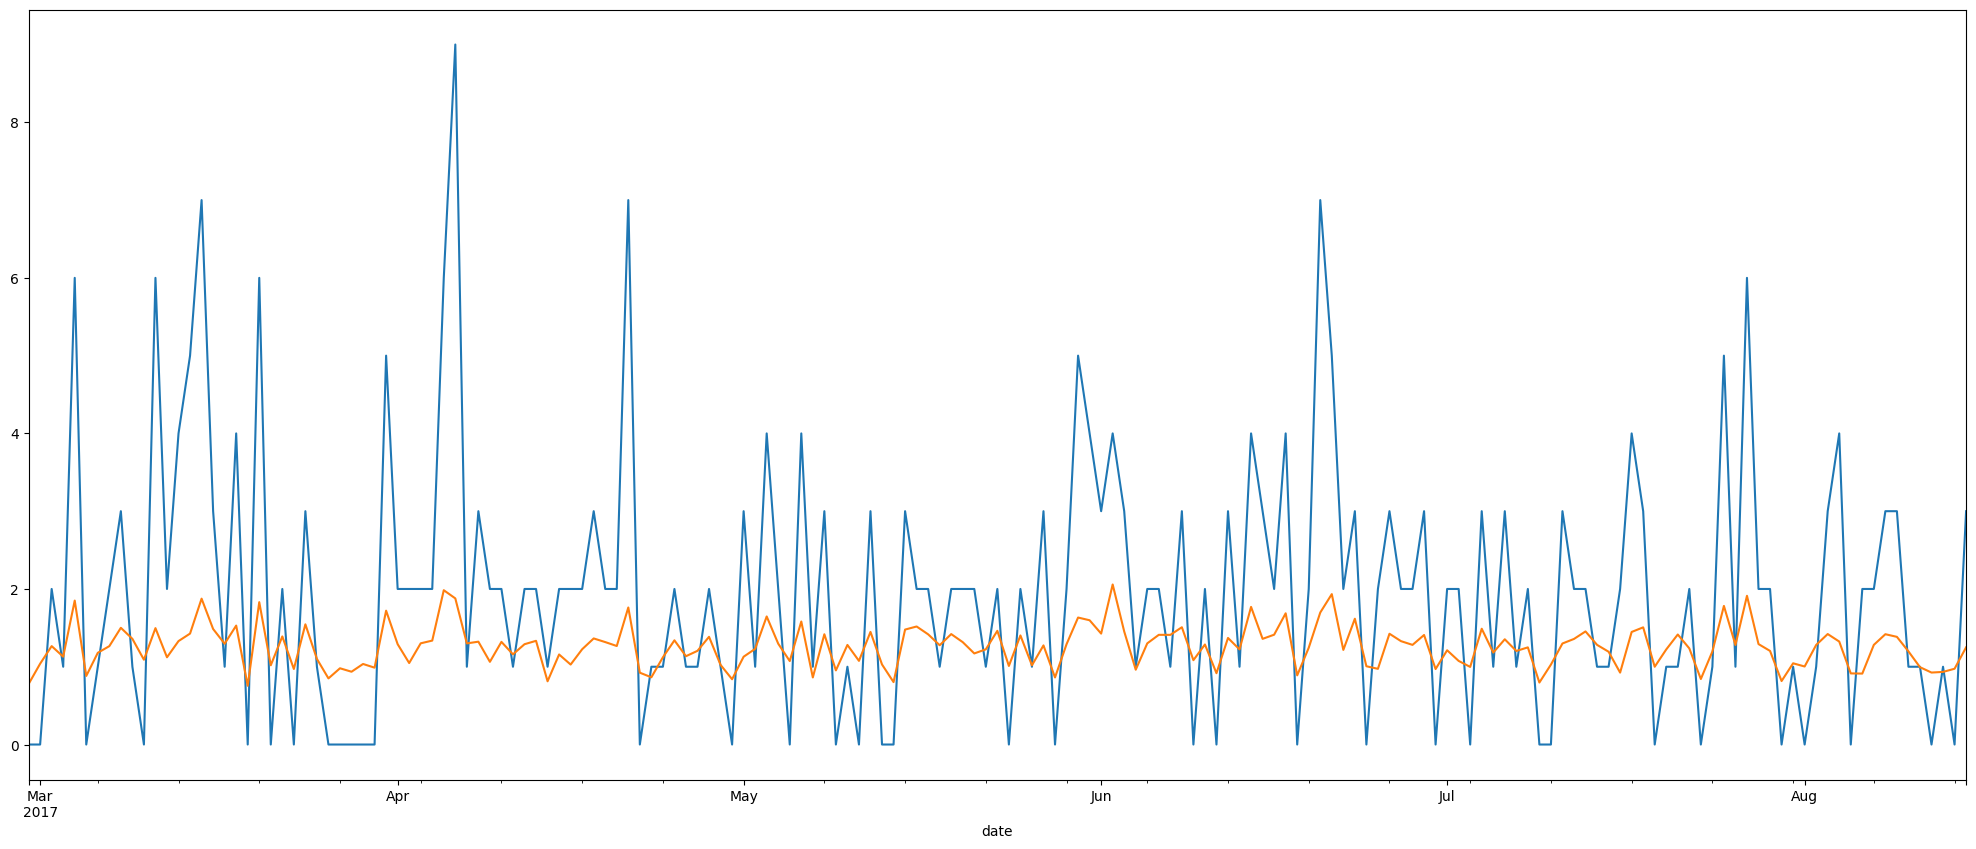

In [94]:
compare('1_HARDWARE')

R2 Score: 0.2903453194767902
RMSLE: 0.5018546349522123


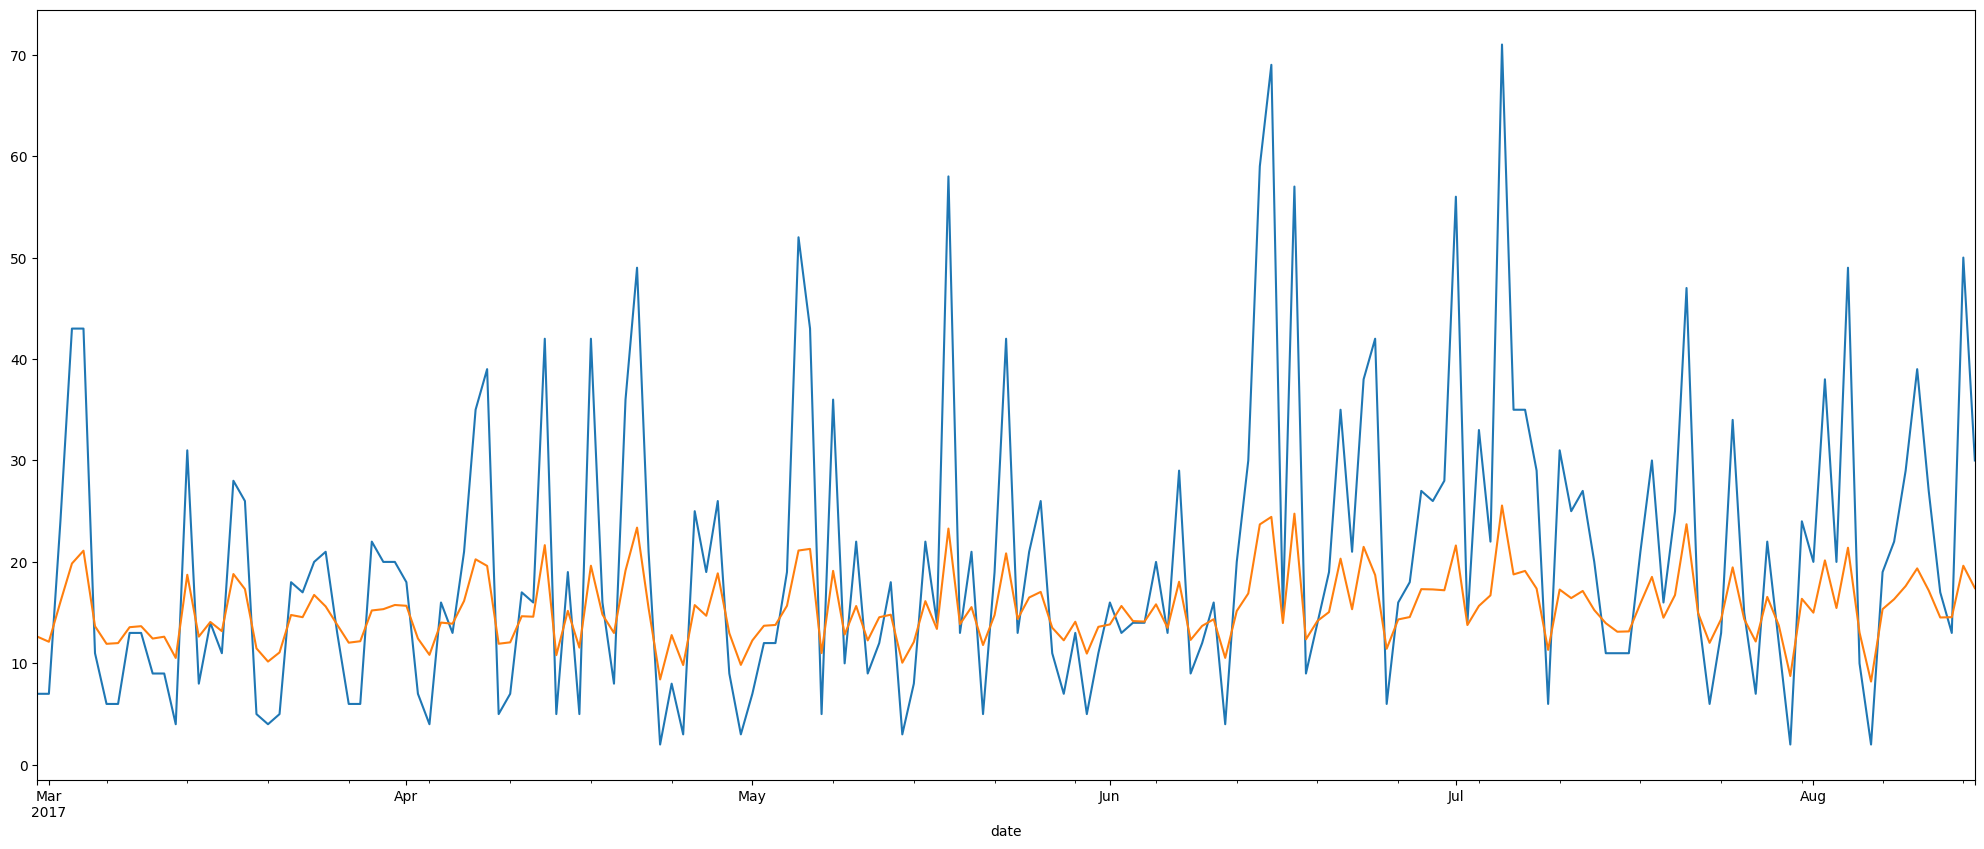

In [95]:
compare('1_HOME AND KITCHEN I')

R2 Score: 0.0008286793250550373
RMSLE: 0.44900219327018887


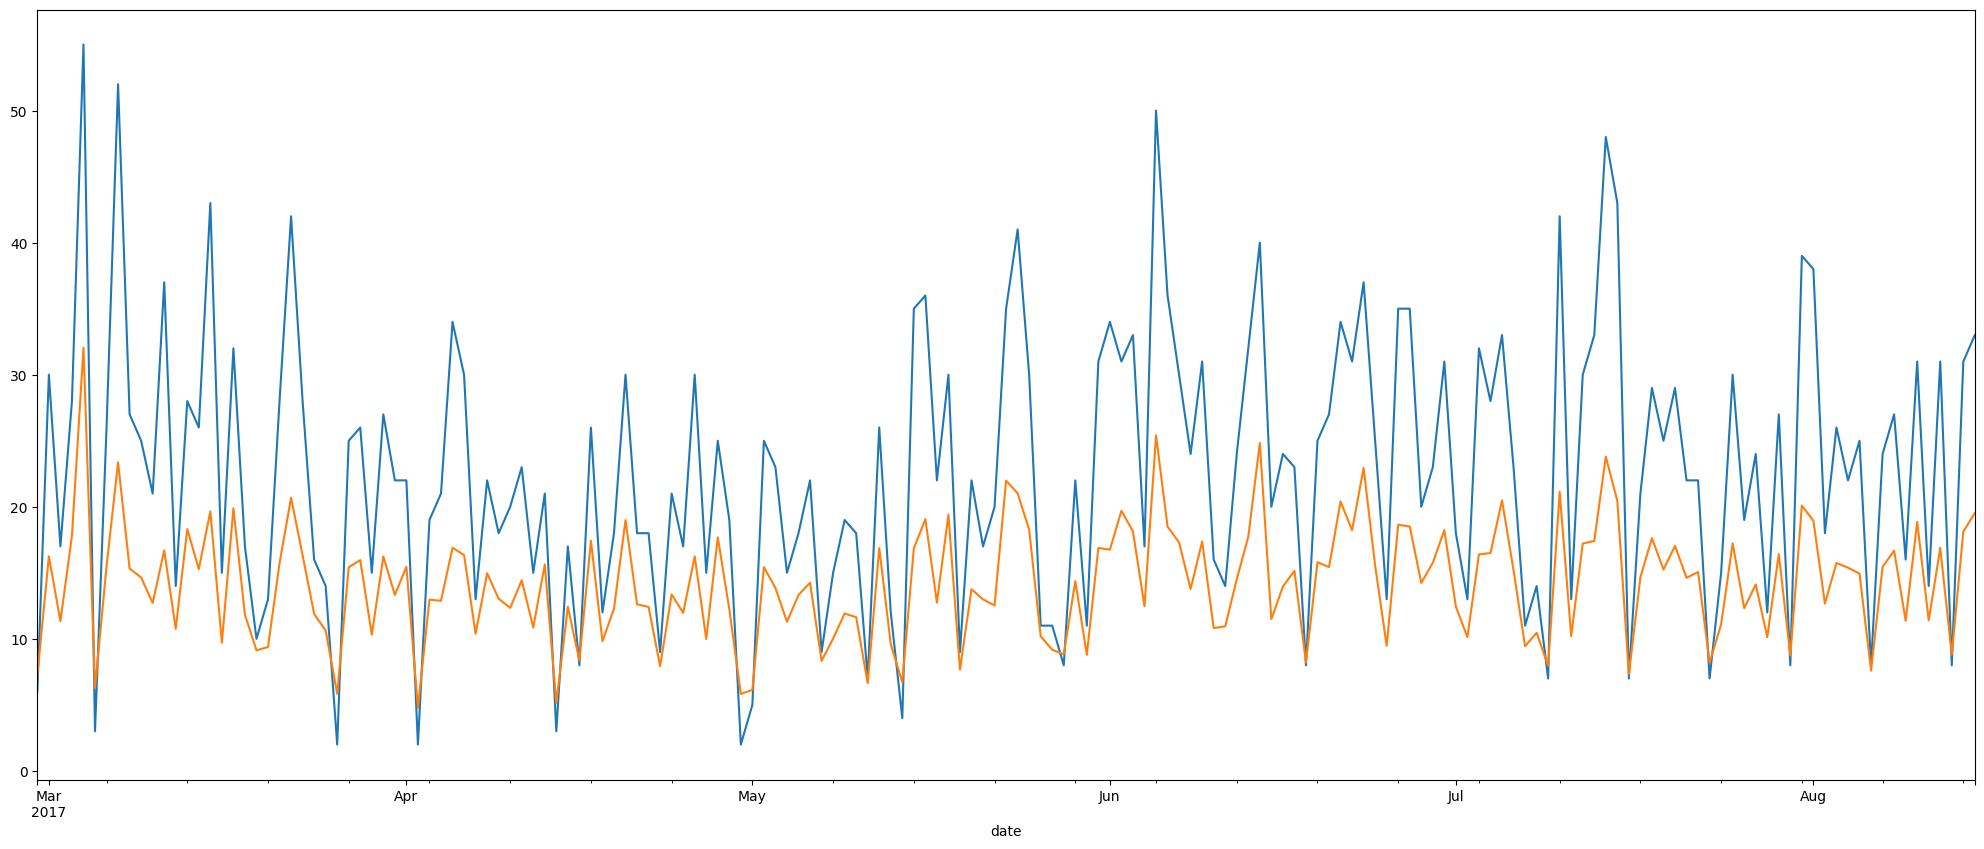

In [96]:
compare('1_HOME AND KITCHEN II')

R2 Score: 0.5454116772152375
RMSLE: 0.2861251139485191


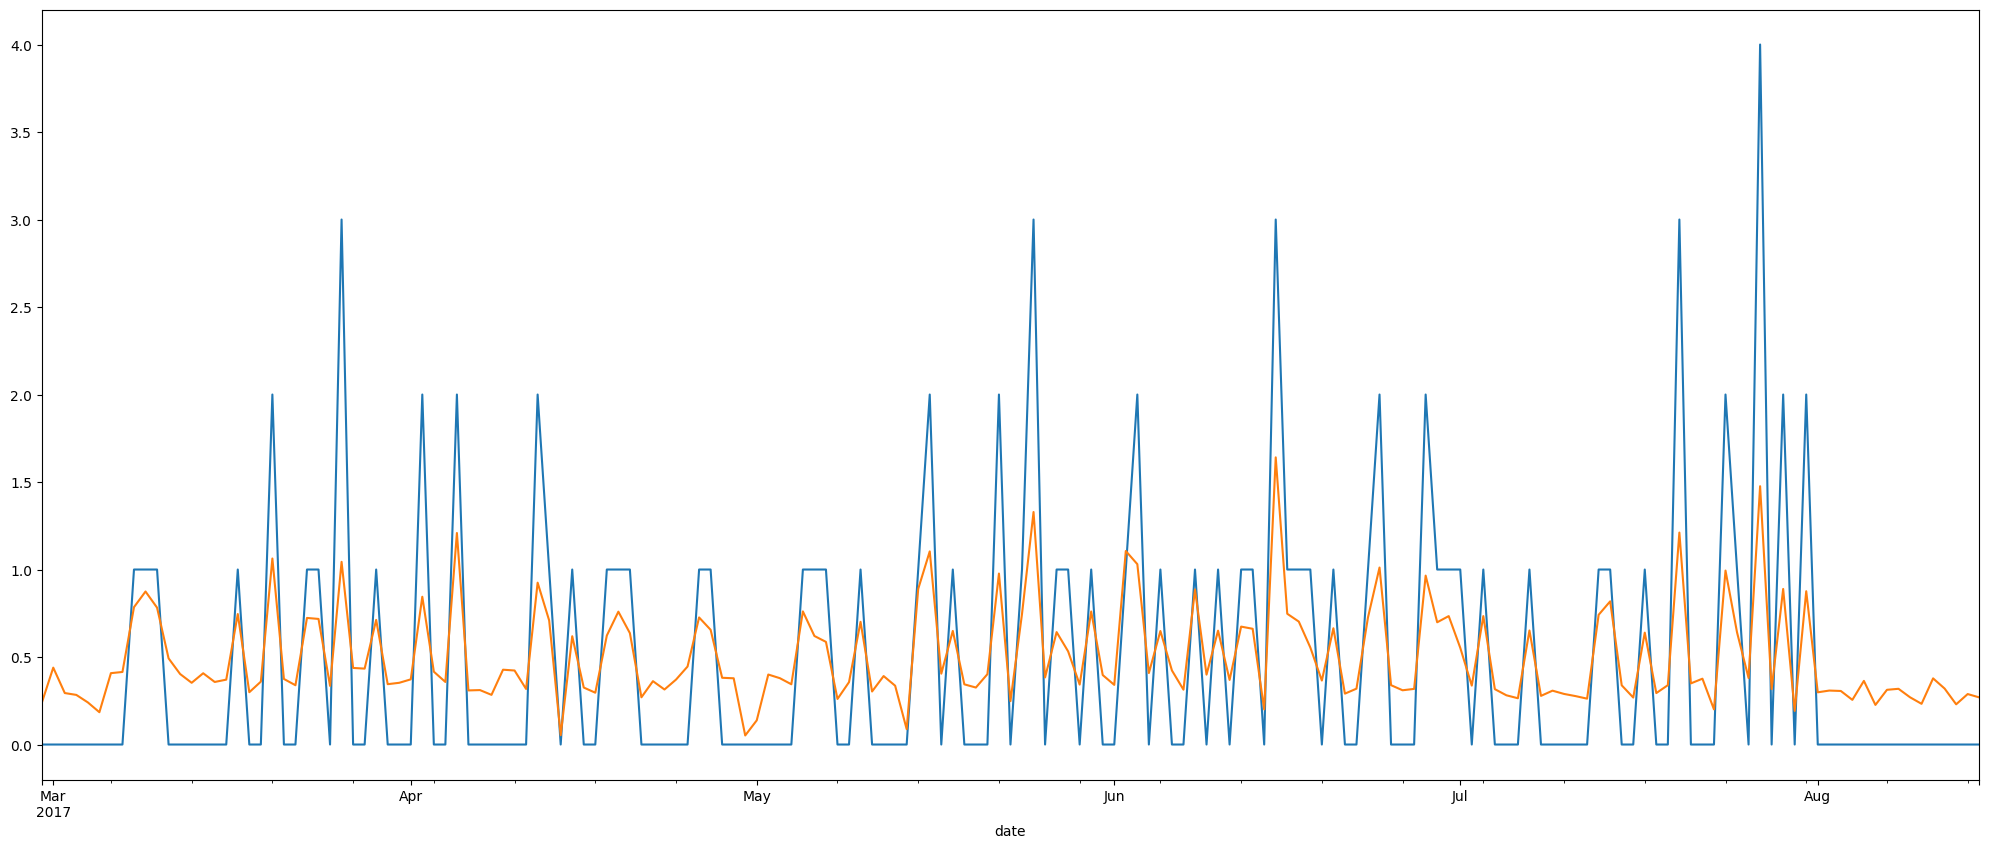

In [97]:
compare('1_HOME APPLIANCES')

R2 Score: 0.6771520872316332
RMSLE: 0.22159400198457233


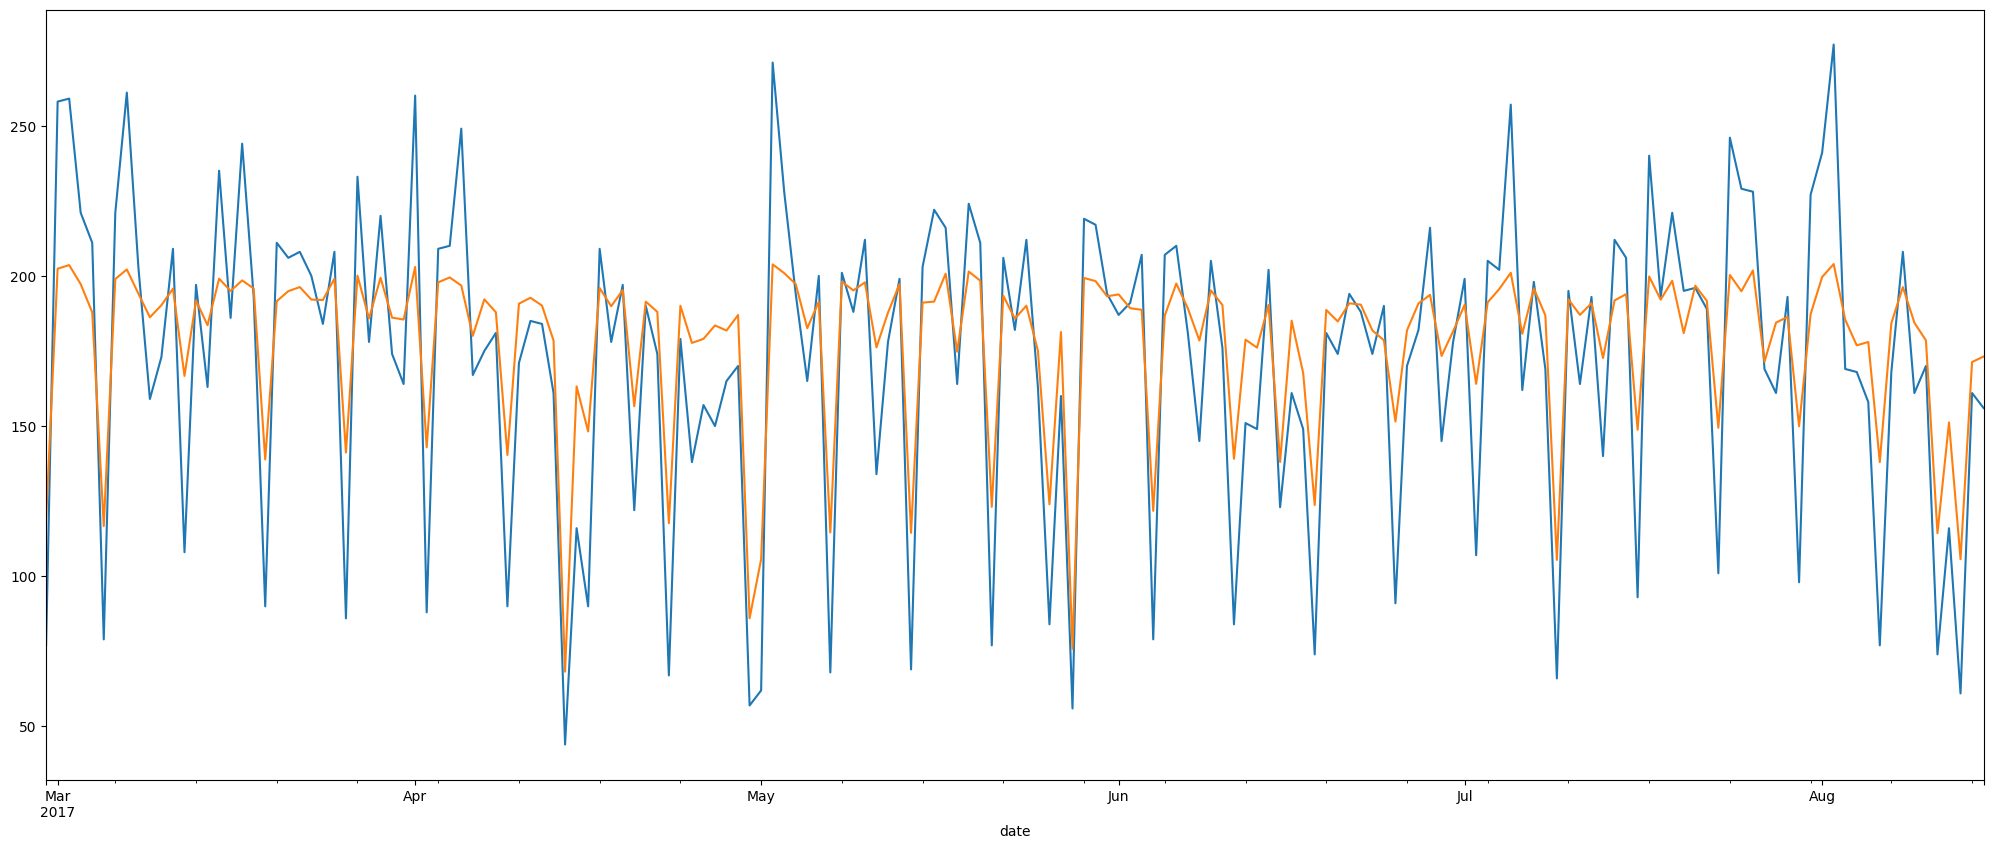

In [98]:
compare('1_HOME CARE')

R2 Score: 0.8181327722840276
RMSLE: 0.19255822816823262


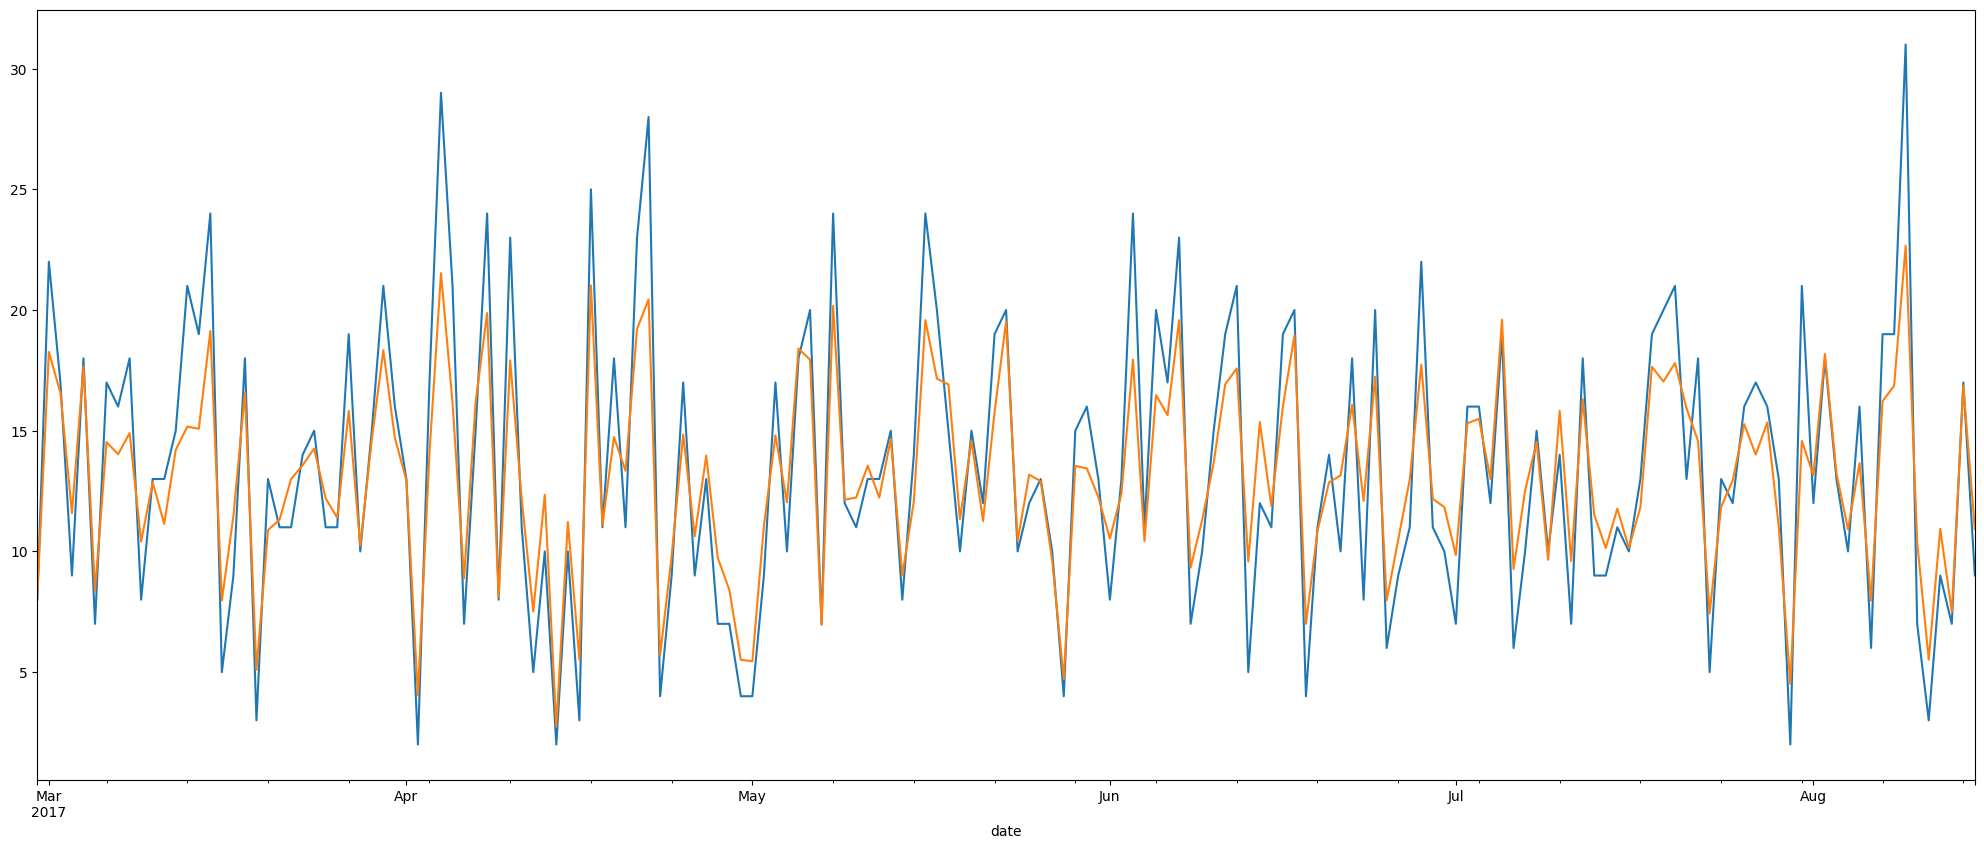

In [99]:
compare('1_LADIESWEAR')

R2 Score: 0.04424942963987766
RMSLE: 0.46751748985988095


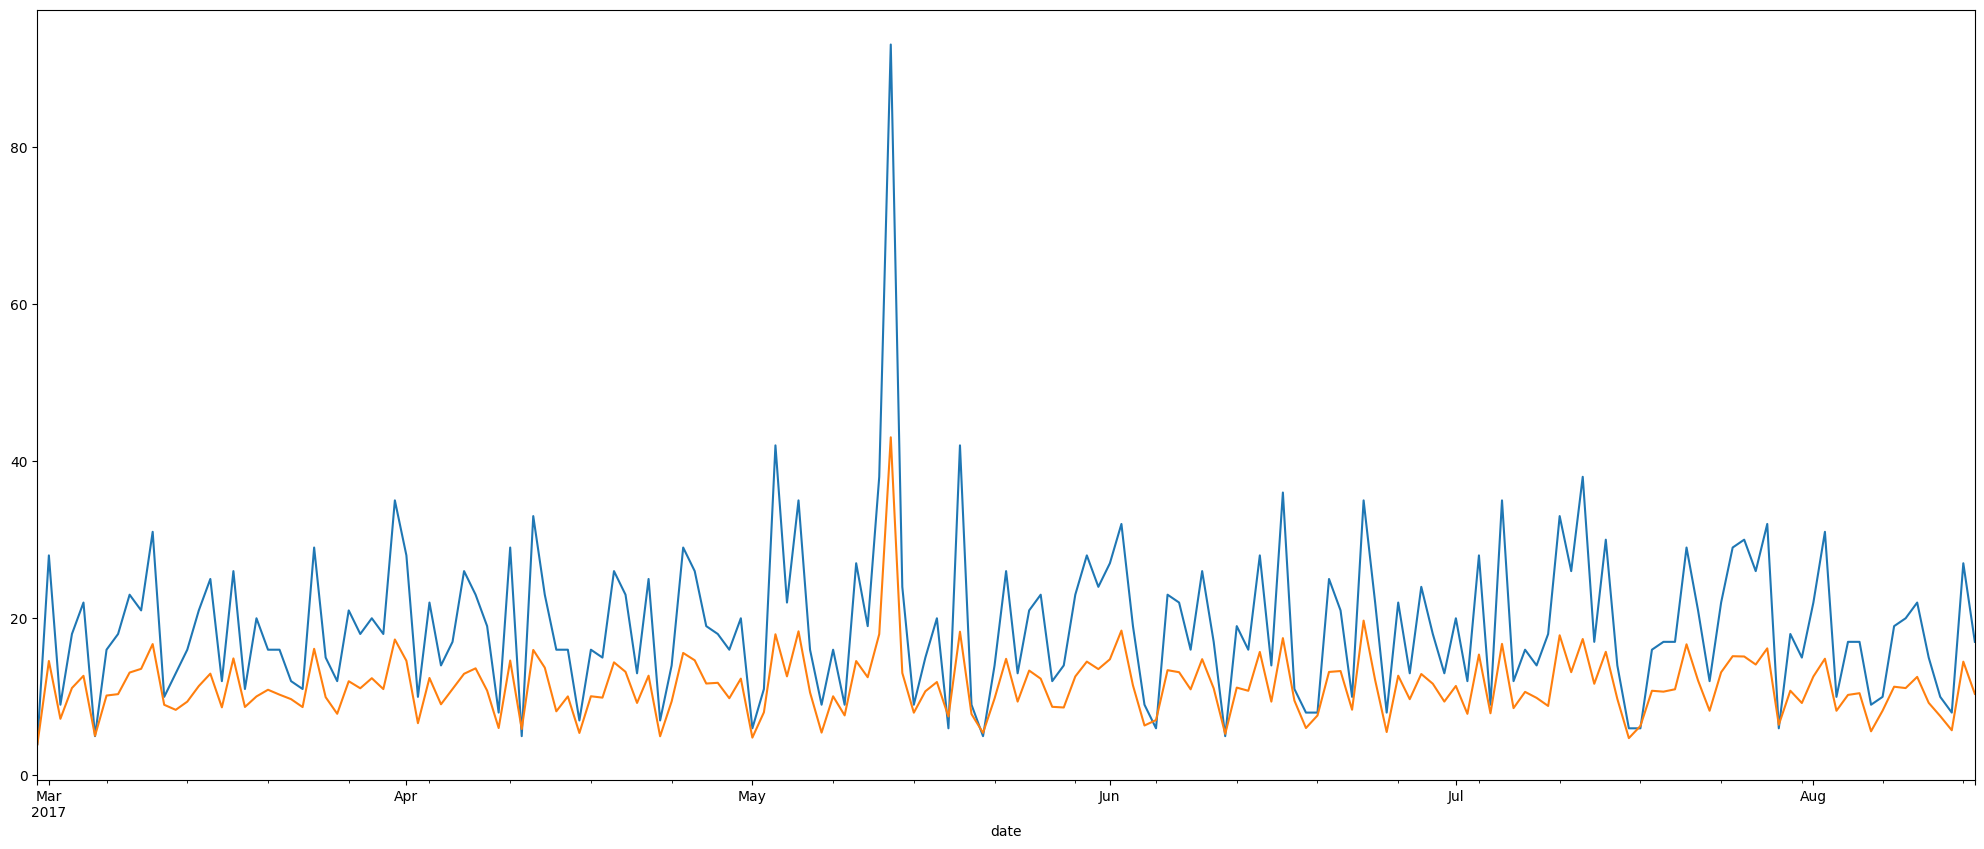

In [100]:
compare('1_LAWN AND GARDEN')

R2 Score: 0.4095797418389877
RMSLE: 0.5308735152269831


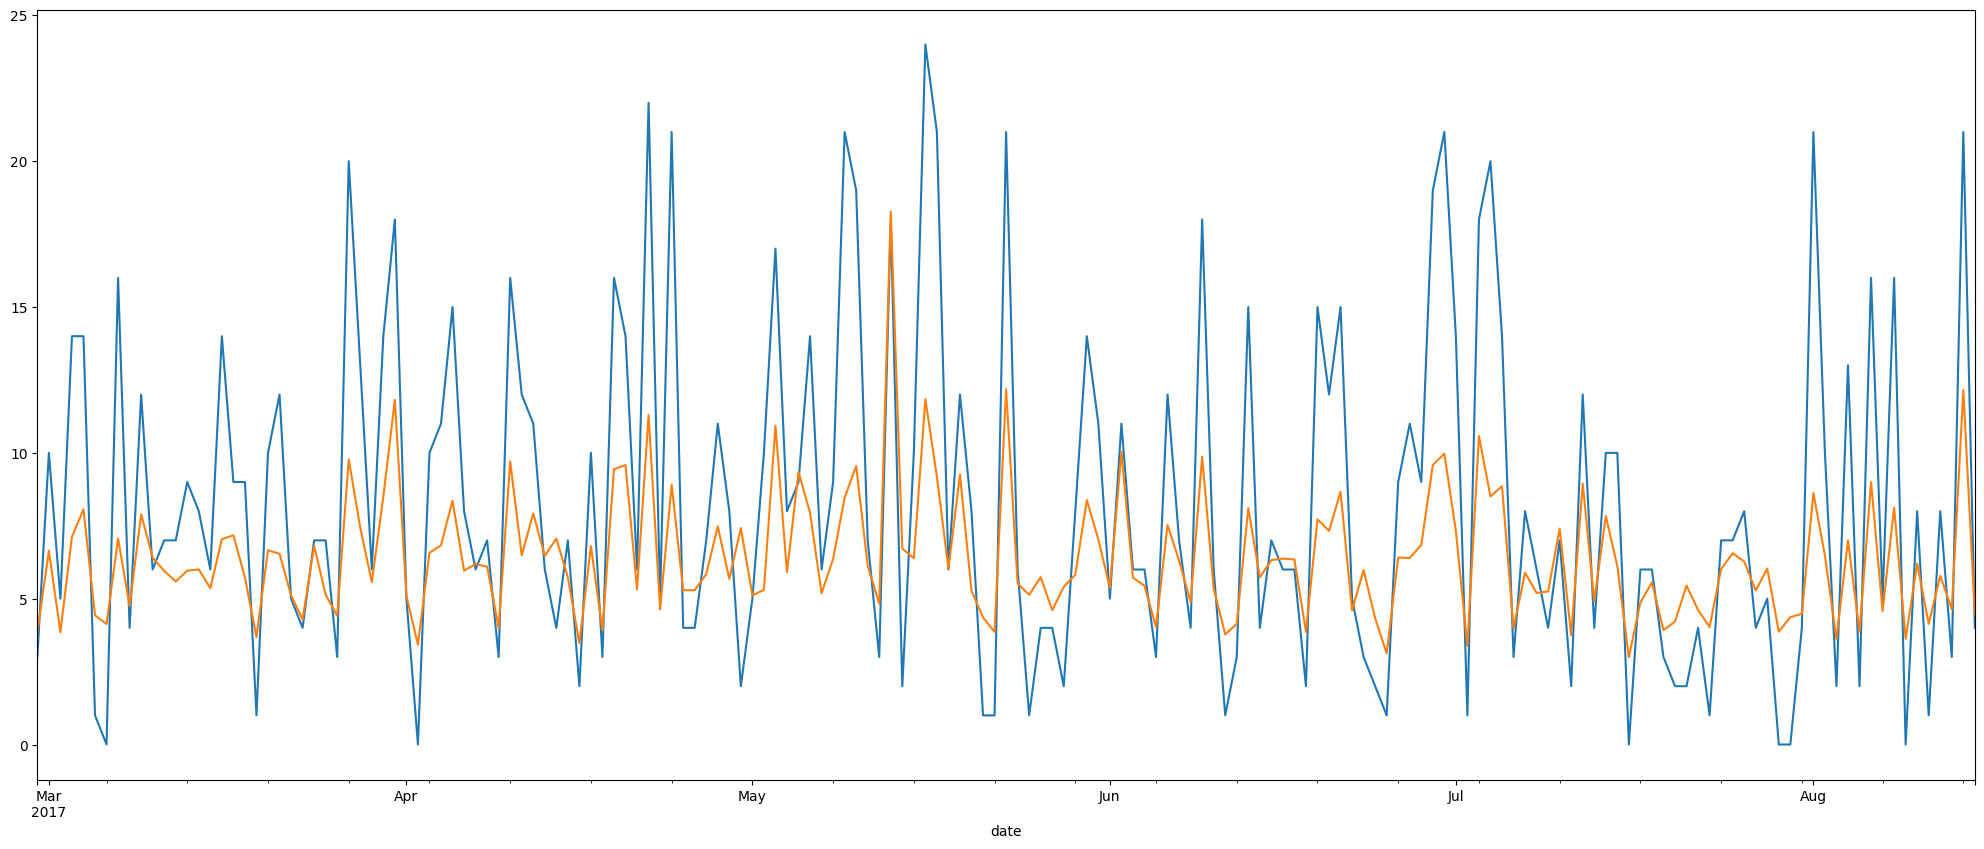

In [101]:
compare('1_LINGERIE')

R2 Score: -0.4808379752118359
RMSLE: 0.7326924570398358


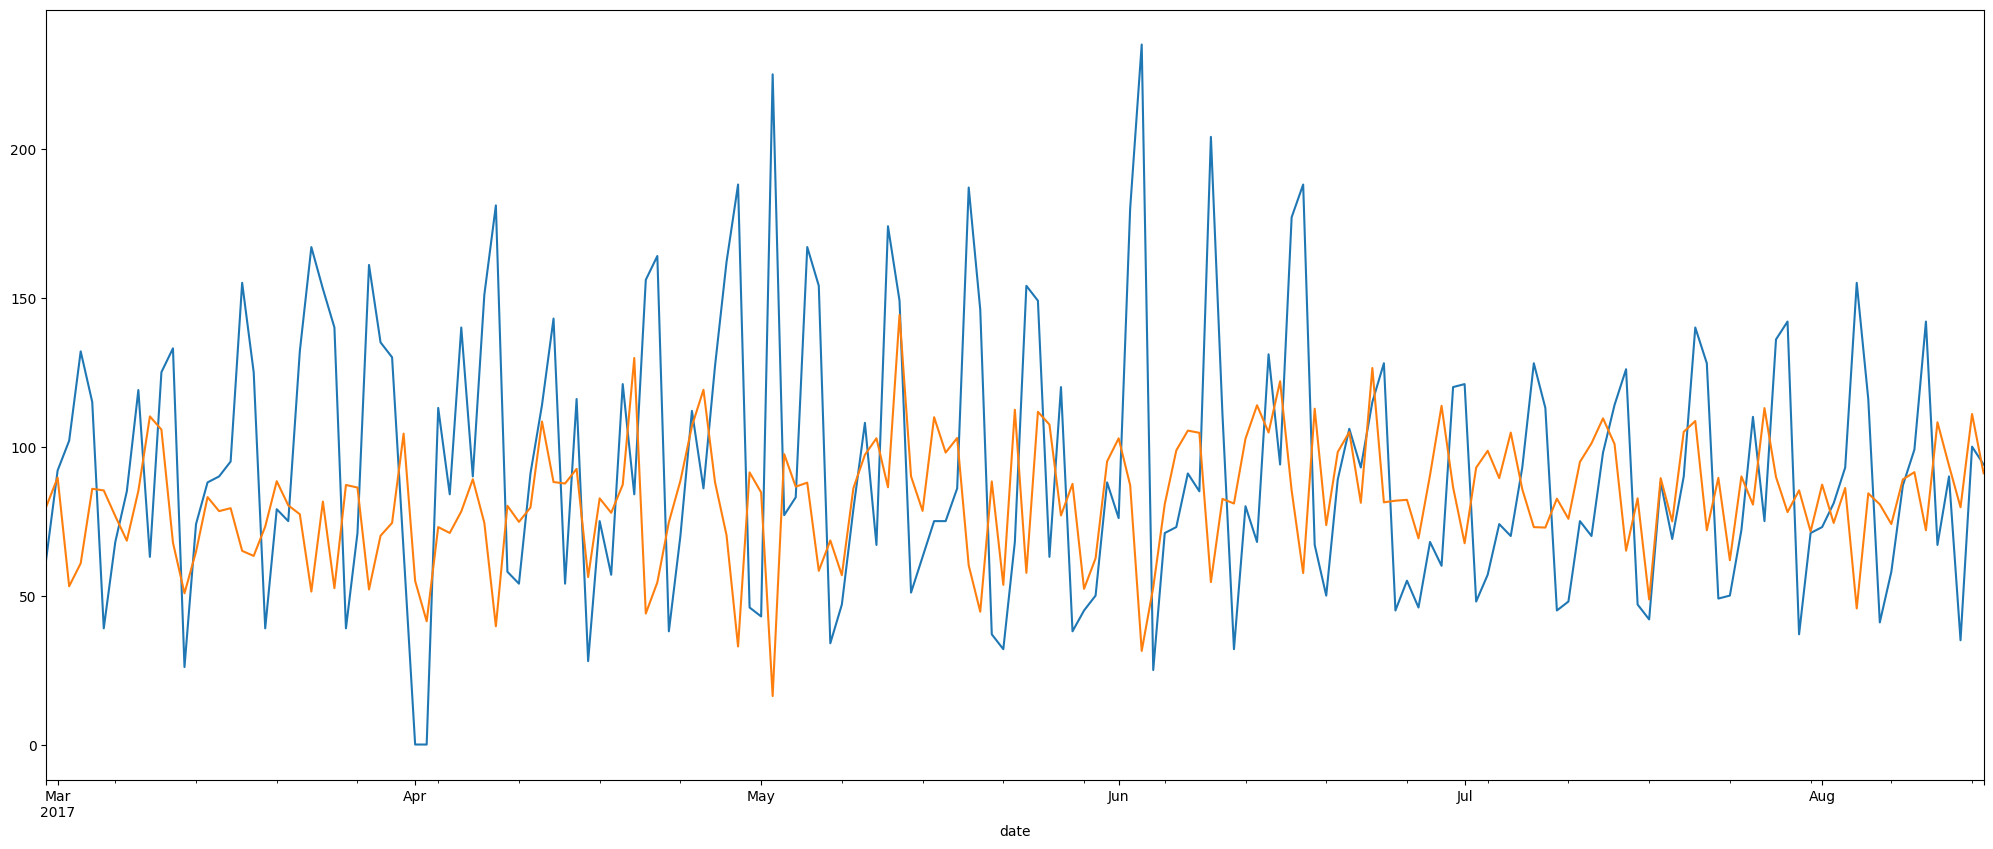

In [102]:
compare('1_LIQUOR,WINE,BEER')

In [103]:
pred

1_AUTOMOTIVE  1_BABY CARE  1_BEAUTY  1_BEVERAGES   1_BOOKS  \
date                                                                     
2017-02-28      2.582522     2.131476  1.939932   198.126144  0.092819   
2017-03-01      2.787700     1.381934  1.884362   194.823578  0.123839   
2017-03-02      2.213413     2.254142  3.285276   199.437805  0.167142   
2017-03-03      2.229027     2.308906  3.482050   200.159866  0.168737   
2017-03-04      2.494184     2.329269  2.583443   200.185654  0.616222   
...                  ...          ...       ...          ...       ...   
2017-08-11      2.787700     1.381934  1.886768   194.426529  0.018147   
2017-08-12      2.494184     2.329268  2.100993   200.115417  0.166647   
2017-08-13      2.787700     1.381934  1.886768   194.395920  0.010262   
2017-08-14      2.787700     1.381934  2.702798   195.133041  0.168882   
2017-08-15      2.113486     2.287780  2.387563   199.777588  0.174099   

            1_BREAD_BAKERY  1_CELEBRATION  1_CLEANING     1_DAIRY      1_DELI  \
date                                                                            
2017-02-28      165.630112       7.599608  205.014587  207.269455   81.228973   
2017-03-01      204.563156      17.521860  206.667297  207.573746  140.294952   
2017-03-02      204.787445      20.461952  207.111801  207.640701   99.148331   
2017-03-03      204.862183      20.769609  207.139465  207.645889  161.970566   
2017-03-04      205.060806       9.146463  205.627701  207.405045  107.972687   
...                    ...            ...         ...         ...         ...   
2017-08-11      180.490662       7.173443  205.195602  207.276810   86.048111   
2017-08-12      204.122787       6.513539  205.312119  207.359985  106.396309   
2017-08-13      174.546982       4.333703  190.697861  206.401154   68.135063   
2017-08-14      204.411163       7.506027  205.459702  207.375198  147.344086   
2017-08-15      204.739365      17.625364  206.758514  207.579529  100.593689   

            ...  54_MAGAZINES    54_MEATS  54_PERSONAL CARE  54_PET SUPPLIES  \
date        ...                                                                
2017-02-28  ...      0.470339   67.672386        200.432800         0.315477   
2017-03-01  ...      1.141055   73.397743        205.633026         1.237218   
2017-03-02  ...      0.996006   77.053253        205.059219         0.445680   
2017-03-03  ...      1.143655   84.031044        205.570892         0.382996   
2017-03-04  ...      1.188764   67.985649        205.383392         0.399876   
...         ...           ...         ...               ...              ...   
2017-08-11  ...      0.497465   70.269257        195.508240         0.438760   
2017-08-12  ...      1.365690   70.367149        199.998611         0.556585   
2017-08-13  ...      2.409593  115.878265        206.653534         1.030056   
2017-08-14  ...      1.229003  100.307266        205.340256         0.738085   
2017-08-15  ...      2.934209   65.540848        200.752274         0.717381   

            54_PLAYERS AND ELECTRONICS  54_POULTRY  54_PREPARED FOODS  \
date                                                                    
2017-02-28                    5.561654   82.232697          61.018955   
2017-03-01                    3.028190   73.325722          59.161762   
2017-03-02                    3.319388   90.197197          59.014973   
2017-03-03                    3.771183   85.851486          60.699108   
2017-03-04                    3.490149   52.287262          95.056549   
...                                ...         ...                ...   
2017-08-11                    1.721108  107.711823          55.020378   
2017-08-12                    3.794894  120.549866          70.812981   
2017-08-13                    4.089365  112.671967          79.495735   
2017-08-14                    3.192929   79.391739         142.977890   
2017-08-15                    3.536439   82.597290          84.183998   

    

In [46]:
col = list(zip([i+1 for i in range(len(train.columns))], train.columns))
col

[(1, '1_AUTOMOTIVE'),
 (2, '1_BABY CARE'),
 (3, '1_BEAUTY'),
 (4, '1_BEVERAGES'),
 (5, '1_BOOKS'),
 (6, '1_BREAD_BAKERY'),
 (7, '1_CELEBRATION'),
 (8, '1_CLEANING'),
 (9, '1_DAIRY'),
 (10, '1_DELI'),
 (11, '1_EGGS'),
 (12, '1_FROZEN FOODS'),
 (13, '1_GROCERY I'),
 (14, '1_GROCERY II'),
 (15, '1_HARDWARE'),
 (16, '1_HOME AND KITCHEN I'),
 (17, '1_HOME AND KITCHEN II'),
 (18, '1_HOME APPLIANCES'),
 (19, '1_HOME CARE'),
 (20, '1_LADIESWEAR'),
 (21, '1_LAWN AND GARDEN'),
 (22, '1_LINGERIE'),
 (23, '1_LIQUOR,WINE,BEER'),
 (24, '1_MAGAZINES'),
 (25, '1_MEATS'),
 (26, '1_PERSONAL CARE'),
 (27, '1_PET SUPPLIES'),
 (28, '1_PLAYERS AND ELECTRONICS'),
 (29, '1_POULTRY'),
 (30, '1_PREPARED FOODS'),
 (31, '1_PRODUCE'),
 (32, '1_SCHOOL AND OFFICE SUPPLIES'),
 (33, '1_SEAFOOD'),
 (34, '2_AUTOMOTIVE'),
 (35, '2_BABY CARE'),
 (36, '2_BEAUTY'),
 (37, '2_BEVERAGES'),
 (38, '2_BOOKS'),
 (39, '2_BREAD_BAKERY'),
 (40, '2_CELEBRATION'),
 (41, '2_CLEANING'),
 (42, '2_DAIRY'),
 (43, '2_DELI'),
 (44, '2_EGGS'),

## LSTM Submission

In [28]:
Y = pd.DataFrame()
for feature in train.columns:
    for step in range(1, 17):
        Y[f'{feature}_step_ahead_{step}'] = train[feature].shift(-step, fill_value=0)
Y

1_AUTOMOTIVE_step_ahead_1  1_AUTOMOTIVE_step_ahead_2  \
date                                                               
2013-01-01                        2.0                        3.0   
2013-01-02                        3.0                        3.0   
2013-01-03                        3.0                        5.0   
2013-01-04                        5.0                        2.0   
2013-01-05                        2.0                        0.0   
...                               ...                        ...   
2017-08-11                        6.0                        1.0   
2017-08-12                        1.0                        1.0   
2017-08-13                        1.0                        4.0   
2017-08-14                        4.0                        0.0   
2017-08-15                        0.0                        0.0   

            1_AUTOMOTIVE_step_ahead_3  1_AUTOMOTIVE_step_ahead_4  \
date                                                               
2013-01-01                        3.0                        5.0   
2013-01-02                        5.0                        2.0   
2013-01-03                        2.0                        0.0   
2013-01-04                        0.0                        2.0   
2013-01-05                        2.0                        2.0   
...                               ...                        ...   
2017-08-11                        1.0                        4.0   
2017-08-12                        4.0                        0.0   
2017-08-13                        0.0                        0.0   
2017-08-14                        0.0                        0.0   
2017-08-15                        0.0                        0.0   

            1_AUTOMOTIVE_step_ahead_5  1_AUTOMOTIVE_step_ahead_6  \
date                                                               
2013-01-01                        2.0                        0.0   
2013-01-02                        0.0                        2.0   
2013-01-03                        2.0                        2.0   
2013-01-04                        2.0                        2.0   
2013-01-05                        2.0                        3.0   
...                               ...                        ...   
2017-08-11                        0.0                        0.0   
2017-08-12                        0.0                        0.0   
2017-08-13                        0.0                        0.0   
2017-08-14                        0.0                        0.0   
2017-08-15                        0.0                        0.0   

            1_AUTOMOTIVE_step_ahead_7  1_AUTOMOTIVE_step_ahead_8  \
date                                                               
2013-01-01                        2.0                        2.0   
2013-01-02                        2.0                        2.0   
2013-01-03                        2.0                        3.0   
2013-01-04                        3.0                        2.0   
2013-01-05                        2.0                        2.0   
...                               ...                        ...   
2017-08-11                        0.0                        0.0   
2017-08-12                        0.0                        0.0   
2017-08-13                        0.0                        0.0   
2017-08-14                        0.0                        0.0   
2017-08-15                        0.0                        0.0   

            1_AUTOMOTIVE_step_ahead_9  1_AUTOMOTIVE_step_ahead_10  ...  \
date                                                               ...   
2013-01-01                        2.0                         3.0  ...   
2013-01-02                        3.0                         2.0  ...   
2013-01-03                        2.0                         2.0  ...   
2013-01-04                        2.0                         2.0  ...   
2013-01-05                  

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], 1782, 16)
y_test = y_test.values.reshape(y_test.shape[0], 1782, 16)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1515, 1782, 1)
(169, 1782, 1)
(1515, 1782, 16)
(169, 1782, 16)


In [30]:
lstm = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(16)
])
lstm.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
lstm.summary()
lstm.fit(X_train, y_train, epochs=100, callbacks=[es])
pred_lstm = abs(lstm.predict(X_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1782, 100)         40800     
                                                                 
 lstm_4 (LSTM)               (None, 1782, 100)         80400     
                                                                 
 lstm_5 (LSTM)               (None, 1782, 100)         80400     
                                                                 
 dense_3 (Dense)             (None, 1782, 16)          1616      
                                                                 
Total params: 203,216
Trainable params: 203,216
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48/48 [==============================] - 10s 152ms/step - loss: 10.1644
Epoch 2/100
48/48 [==============================] - 7s 151ms/step - loss: 8.3947
Epoch 3/100
48

In [31]:
pred = pd.DataFrame(pred_lstm[168].T, columns=X.columns, index=test.index.unique())
pred

1_AUTOMOTIVE  1_BABY CARE  1_BEAUTY  1_BEVERAGES   1_BOOKS  \
date                                                                     
2017-08-16      2.355941     1.059757  1.908306   157.504715  0.428838   
2017-08-17      2.192654     0.989042  1.943323   142.463669  0.272173   
2017-08-18      2.207404     0.965431  1.988186   143.955368  0.348896   
2017-08-19      2.068743     0.617542  2.118440   114.562157  0.229112   
2017-08-20      2.283131     0.846595  2.051922   142.906082  0.271756   
2017-08-21      2.218533     0.755243  2.015010   138.090546  0.243749   
2017-08-22      2.396008     0.757386  2.012664   149.890427  0.281276   
2017-08-23      2.363967     0.729325  2.116335   141.547348  0.246481   
2017-08-24      2.475238     0.786162  2.097929   154.441269  0.272514   
2017-08-25      2.279555     0.716533  2.071261   145.426193  0.227010   
2017-08-26      2.307885     0.614404  2.120346   136.273102  0.119322   
2017-08-27      2.552463     0.659792  2.177821   151.089645  0.207314   
2017-08-28      2.189193     0.399054  2.261920   107.637894  0.110037   
2017-08-29      2.317849     0.543330  2.092820   131.707718  0.123616   
2017-08-30      2.499843     0.690460  2.097618   154.901245  0.137842   
2017-08-31      2.414345     0.572791  2.139890   143.316818  0.092870   

            1_BREAD_BAKERY  1_CELEBRATION  1_CLEANING     1_DAIRY      1_DELI  \
date                                                                            
2017-08-16      160.524338      10.144552  160.787857  160.782837  156.893005   
2017-08-17      145.193161       9.786385  145.426834  145.422226  142.074112   
2017-08-18      146.705292      10.030747  146.940765  146.936188  143.553467   
2017-08-19      116.787209      10.060716  116.965714  116.962761  114.569527   
2017-08-20      145.651688       9.819310  145.883759  145.879059  142.473679   
2017-08-21      140.743195       9.832994  140.961960  140.957489  137.727997   
2017-08-22      152.778595      10.095300  153.016403  153.011581  149.462997   
2017-08-23      144.267929       9.710745  144.499680  144.495163  141.180557   
2017-08-24      157.396942       9.971336  157.647247  157.641876  153.859863   
2017-08-25      148.236084       9.868437  148.472229  148.467499  144.992508   
2017-08-26      138.880417       9.760609  139.092560  139.088348  135.994781   
2017-08-27      154.001511       9.991518  154.242142  154.236923  150.644791   
2017-08-28      109.780037       9.515769  109.963249  109.960281  107.659019   
2017-08-29      134.213898       9.671391  134.418869  134.414886  131.401123   
2017-08-30      157.868240       9.904486  158.116287  158.110962  154.312714   
2017-08-31      146.039719       9.865387  146.262421  146.257553  142.855179   

            ...  54_MAGAZINES   54_MEATS  54_PERSONAL CARE  54_PET SUPPLIES  \
date        ...                                                               
2017-08-16  ...      1.128864  78.109482        160.269302         0.317271   
2017-08-17  ...      1.196305  72.806023        144.971176         0.395756   
2017-08-18  ...      1.183352  72.603310        146.473190         0.343690   
2017-08-19  ...      1.087418  62.617920        116.630516         0.320892   
2017-08-20  ...      1.152723  71.727234        145.418472         0.383422   
2017-08-21  ...      1.110307  70.596939        140.520050         0.369947   
2017-08-22  ...      1.108099  75.103394        152.528442         0.339561   
2017-08-23  ...      1.207145  71.880989        144.042755         0.405704   
2017-08-24  ...      1.180611  76.756874        157.135712         0.404360   
2017-08-25  ...      1.231369  73.371147        148.002228         0.416754   
2017-08-26  ...      1.135420  69.998764        138.662079         0.448873   
2017-08-27  ...      1.200206  75.228165        153.741623         0.425040   
2017-08-28  ...      1.205623  58.586311        109.640022         0.499801   
2017-08-29  ...      1.185832  68.0

In [32]:
id = []
sales = []
for i in test.id:
    row = test[test['id'] == i]
    column = f"{row['store_nbr'][0]}_{row['family'][0].replace('/', '_')}"
    value = pred[column][pred.index == row.index[0]][0]
    # The info from the ID row is taken and used to form a variable called column. 
    # This column variable refers to the correct store in the dataframe and the equality check on the indexes refer to the proper dates lining up.
    id.append(i)
    sales.append(value)
lstm_submission = pd.DataFrame({'id': id, 'sales': sales})
lstm_submission

id       sales
0      3000888    2.355941
1      3000889    1.059757
2      3000890    1.908306
3      3000891  157.504715
4      3000892    0.428838
...        ...         ...
28507  3029395  146.226639
28508  3029396  142.493179
28509  3029397  146.266418
28510  3029398   49.064888
28511  3029399   13.267859

[28512 rows x 2 columns]

In [33]:
lstm_submission.to_csv('LSTM_submission.csv', header=True, index=False)

# Further Experimentation

## Exog as X

In [15]:
exog = pickle.load(open('exog.pkl', 'rb'))
X = exog
Y = train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
y_test_copy = y_test
y_test_index = y_test.index
X_train = X_train.values.reshape(1, X_train.shape[0], X_train.shape[1])
X_test = X_test.values.reshape(1, X_test.shape[0], X_test.shape[1])
y_train = y_train.values.reshape(1, y_train.shape[0], y_train.shape[1])
y_test = y_test.values.reshape(1, y_test.shape[0], y_test.shape[1])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1, 1515, 26)
(1, 169, 26)
(1, 1515, 1782)
(1, 169, 1782)


In [16]:
def compare(column):
    df_test = y_test_copy[column]
    prediction = pred[column]
    df_test.plot(figsize=(25, 10))
    prediction.plot()
    print(f"R2 Score: {r2_score(df_test, prediction)}")
    print(f"RMSLE: {mean_squared_log_error(df_test, prediction, squared=False)}")

In [17]:
%load_ext tensorboard


In [20]:
%tensorboard --logdir logs

In [18]:
log_dir = "logs/fit/" + dt.now().strftime('%m/%d/%Y %-I:%M:%S %p')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
lstm = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, X_train.shape[2]]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(1782, activation='relu')
])
lstm.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
lstm.summary()
lstm.fit(X_train, y_train, epochs=200, callbacks=[tensorboard])
pred_lstm = lstm.predict(X_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, None, 100)         50800     
                                                                 
 lstm_6 (LSTM)               (None, None, 100)         80400     
                                                                 
 lstm_7 (LSTM)               (None, None, 100)         80400     
                                                                 
 lstm_8 (LSTM)               (None, None, 100)         80400     
                                                                 
 dense_2 (Dense)             (None, None, 1782)        179982    
                                                                 
Total params: 471,982
Trainable params: 471,982
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1/1 [==============================]

In [28]:
print(pred_lstm.shape)
pred_lstm

(1, 169, 1782)


array([[[0.        , 0.        , 0.24743585, ..., 1.2726338 ,
         0.        , 0.15153566],
        [0.        , 0.        , 1.2159871 , ..., 6.307753  ,
         0.        , 0.69019604],
        [0.        , 0.        , 1.7267306 , ..., 9.059463  ,
         0.        , 0.9596934 ],
        ...,
        [0.        , 0.        , 1.8366827 , ..., 9.672125  ,
         0.        , 1.0204936 ],
        [0.        , 0.        , 1.8366827 , ..., 9.672125  ,
         0.        , 1.0204936 ],
        [0.        , 0.        , 1.8366827 , ..., 9.672125  ,
         0.        , 1.0204936 ]]], dtype=float32)

In [29]:
pred_lstm = pred_lstm.reshape(169, 1782)
pred = pd.DataFrame(pred_lstm, columns=Y.columns, index=y_test_index)
pred

1_AUTOMOTIVE  1_BABY CARE  1_BEAUTY  1_BEVERAGES  1_BOOKS  \
date                                                                    
2017-02-28           0.0          0.0  0.247436     1.608304      0.0   
2017-03-01           0.0          0.0  1.215987     7.986695      0.0   
2017-03-02           0.0          0.0  1.726731    11.505701      0.0   
2017-03-03           0.0          0.0  1.818966    12.163808      0.0   
2017-03-04           0.0          0.0  1.833779    12.272660      0.0   
...                  ...          ...       ...          ...      ...   
2017-08-11           0.0          0.0  1.836683    12.294867      0.0   
2017-08-12           0.0          0.0  1.836683    12.294867      0.0   
2017-08-13           0.0          0.0  1.836683    12.294867      0.0   
2017-08-14           0.0          0.0  1.836683    12.294867      0.0   
2017-08-15           0.0          0.0  1.836683    12.294867      0.0   

            1_BREAD_BAKERY  1_CELEBRATION  1_CLEANING  1_DAIRY     1_DELI  \
date                                                                        
2017-02-28        1.501718       0.416768    1.530053      0.0   1.424702   
2017-03-01        7.423543       2.092147    7.590078      0.0   7.051256   
2017-03-02       10.694398       3.030896   10.942007      0.0  10.148626   
2017-03-03       11.307422       3.207568   11.572404      0.0  10.728320   
2017-03-04       11.408977       3.236889   11.677077      0.0  10.824129   
...                    ...            ...         ...      ...        ...   
2017-08-11       11.429727       3.242895   11.698519      0.0  10.843637   
2017-08-12       11.429727       3.242895   11.698519      0.0  10.843637   
2017-08-13       11.429727       3.242895   11.698519      0.0  10.843637   
2017-08-14       11.429727       3.242895   11.698519      0.0  10.843637   
2017-08-15       11.429727       3.242895   11.698519      0.0  10.843637   

            ...  54_MAGAZINES  54_MEATS  54_PERSONAL CARE  54_PET SUPPLIES  \
date        ...                                                              
2017-02-28  ...      0.027391  1.222515          1.348207         0.004022   
2017-03-01  ...      0.153012  6.058450          6.679204         0.035667   
2017-03-02  ...      0.225881  8.766927          9.620711         0.055713   
2017-03-03  ...      0.239779  9.280592         10.173656         0.060189   
2017-03-04  ...      0.242008  9.366265         10.265360         0.060971   
...         ...           ...       ...               ...              ...   
2017-08-11  ...      0.242436  9.383898         10.284101         0.061134   
2017-08-12  ...      0.242436  9.383898         10.284100         0.061134   
2017-08-13  ...      0.242436  9.383898         10.284100         0.061134   
2017-08-14  ...      0.242436  9.383898         10.284100         0.061134   
2017-08-15  ...      0.242436  9.383898         10.284100         0.061134   

            54_PLAYERS AND ELECTRONICS  54_POULTRY  54_PREPARED FOODS  \
date                                                                    
2017-02-28                         0.0    1.091538           1.305126   
2017-03-01                         0.0    5.382789           6.447579   
2017-03-02                         0.0    7.766068           9.262403   
2017-03-03                         0.0    8.215658           9.787208   
2017-03-04                         0.0    8.290428           9.874080   
...                                ...         ...                ...   
2017-08-11                         0.0    8.305767           9.891857   
2017-08-12                         0.0    8.305767           9.891857   
2017-08-13                         0.0    8.305767           9.891856   
2017-08-14                         0.0    8.305767           9.891856   
2017-08-15                         0.0    8.305767           9.891856   

            54_PRODUCE  54_SCHOOL AND OFFICE SUPPLIES  54_SEAFOOD  
date                       

R2 Score: -2.195534100315916
RMSLE: 1.6152030488276374


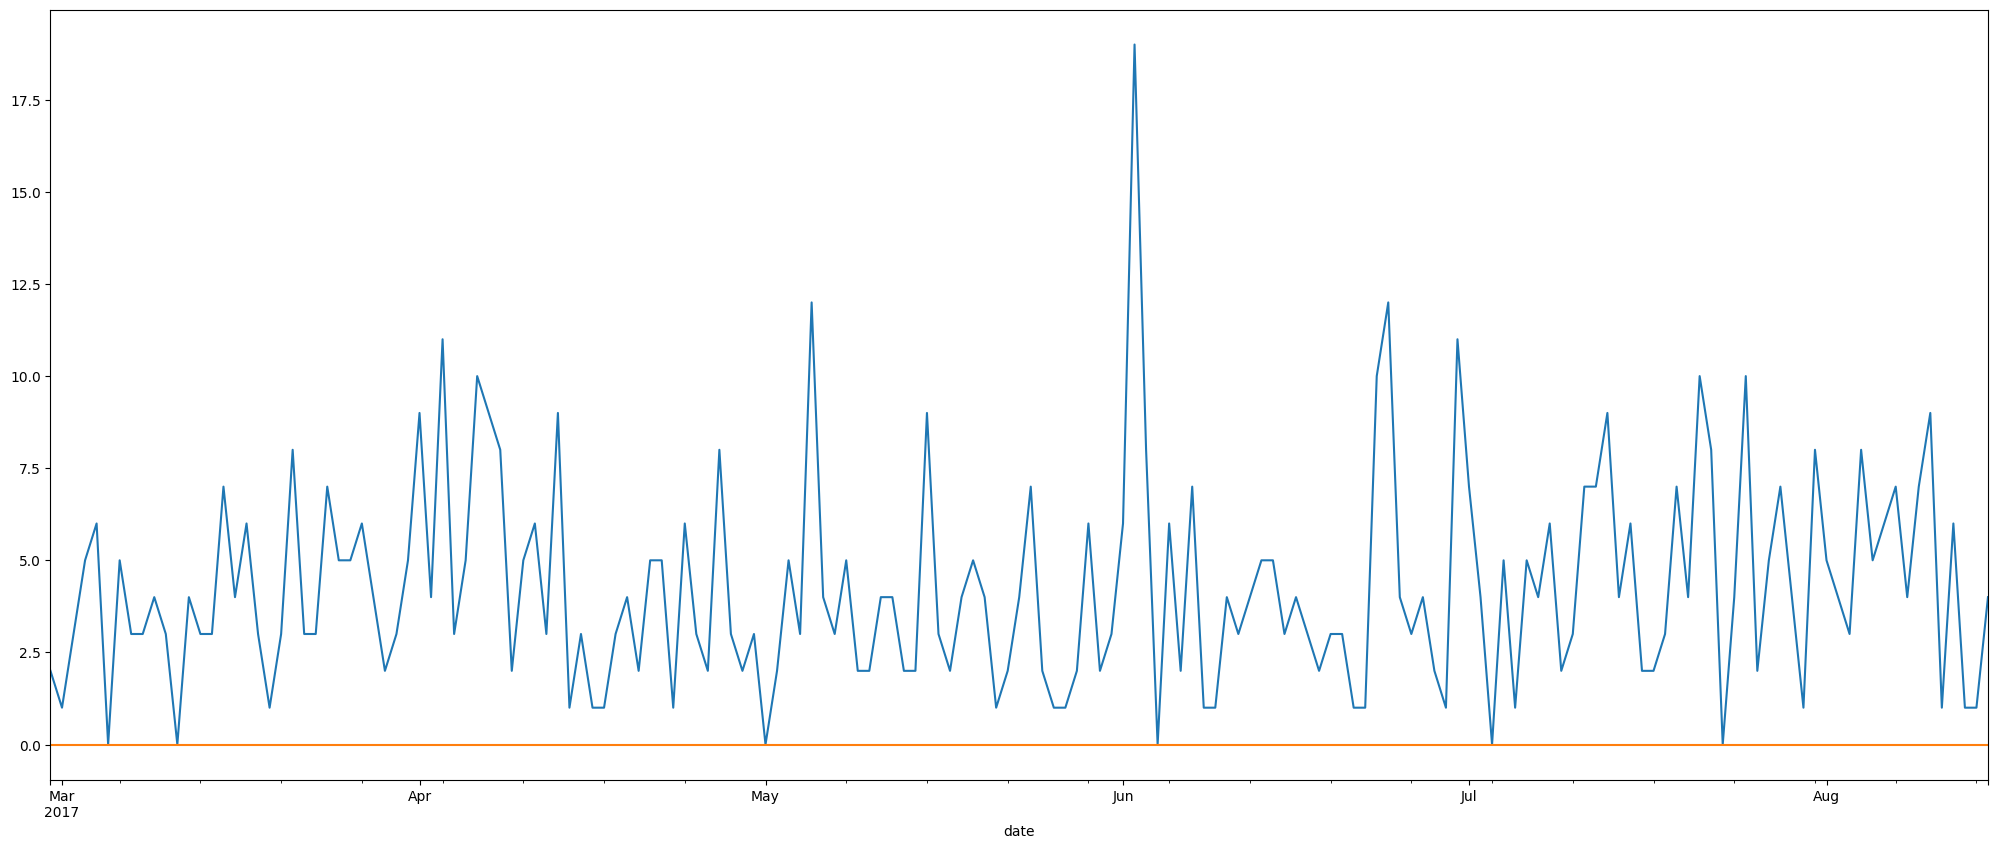

In [30]:
compare('1_AUTOMOTIVE')

R2 Score: -8.648607818836972
RMSLE: 3.9125353143919104


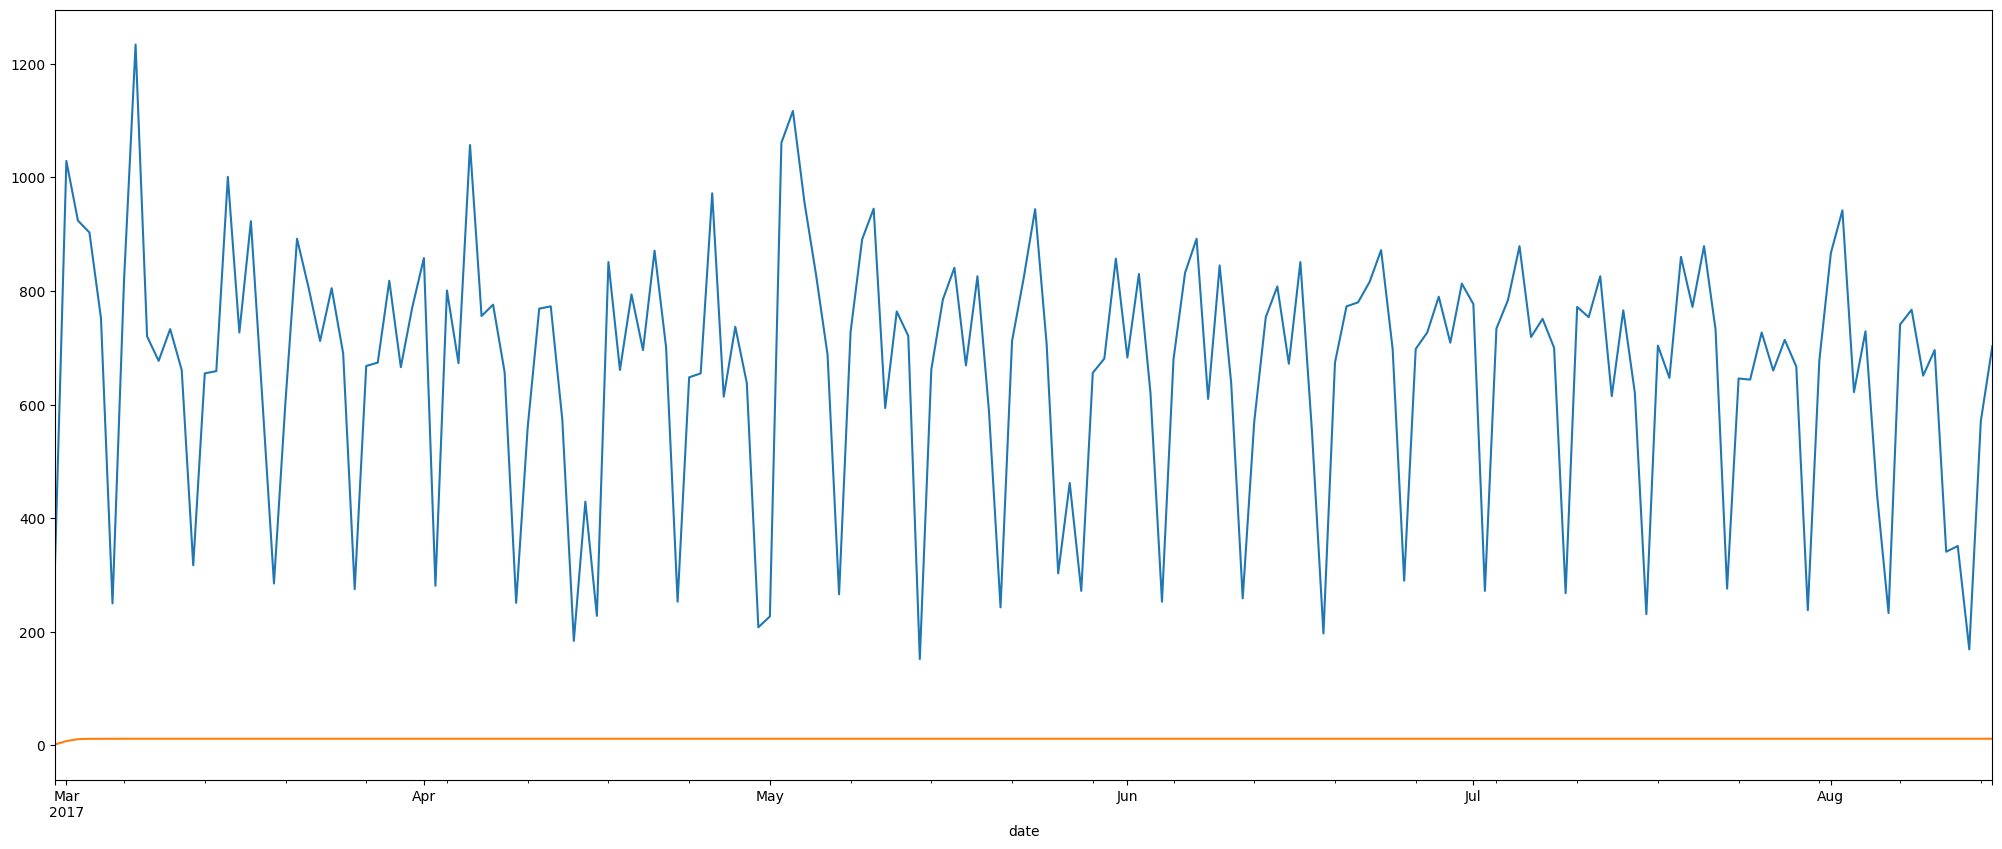

In [31]:
compare('1_CLEANING')

R2 Score: -13.536031317460091
RMSLE: 6.5427952719506655


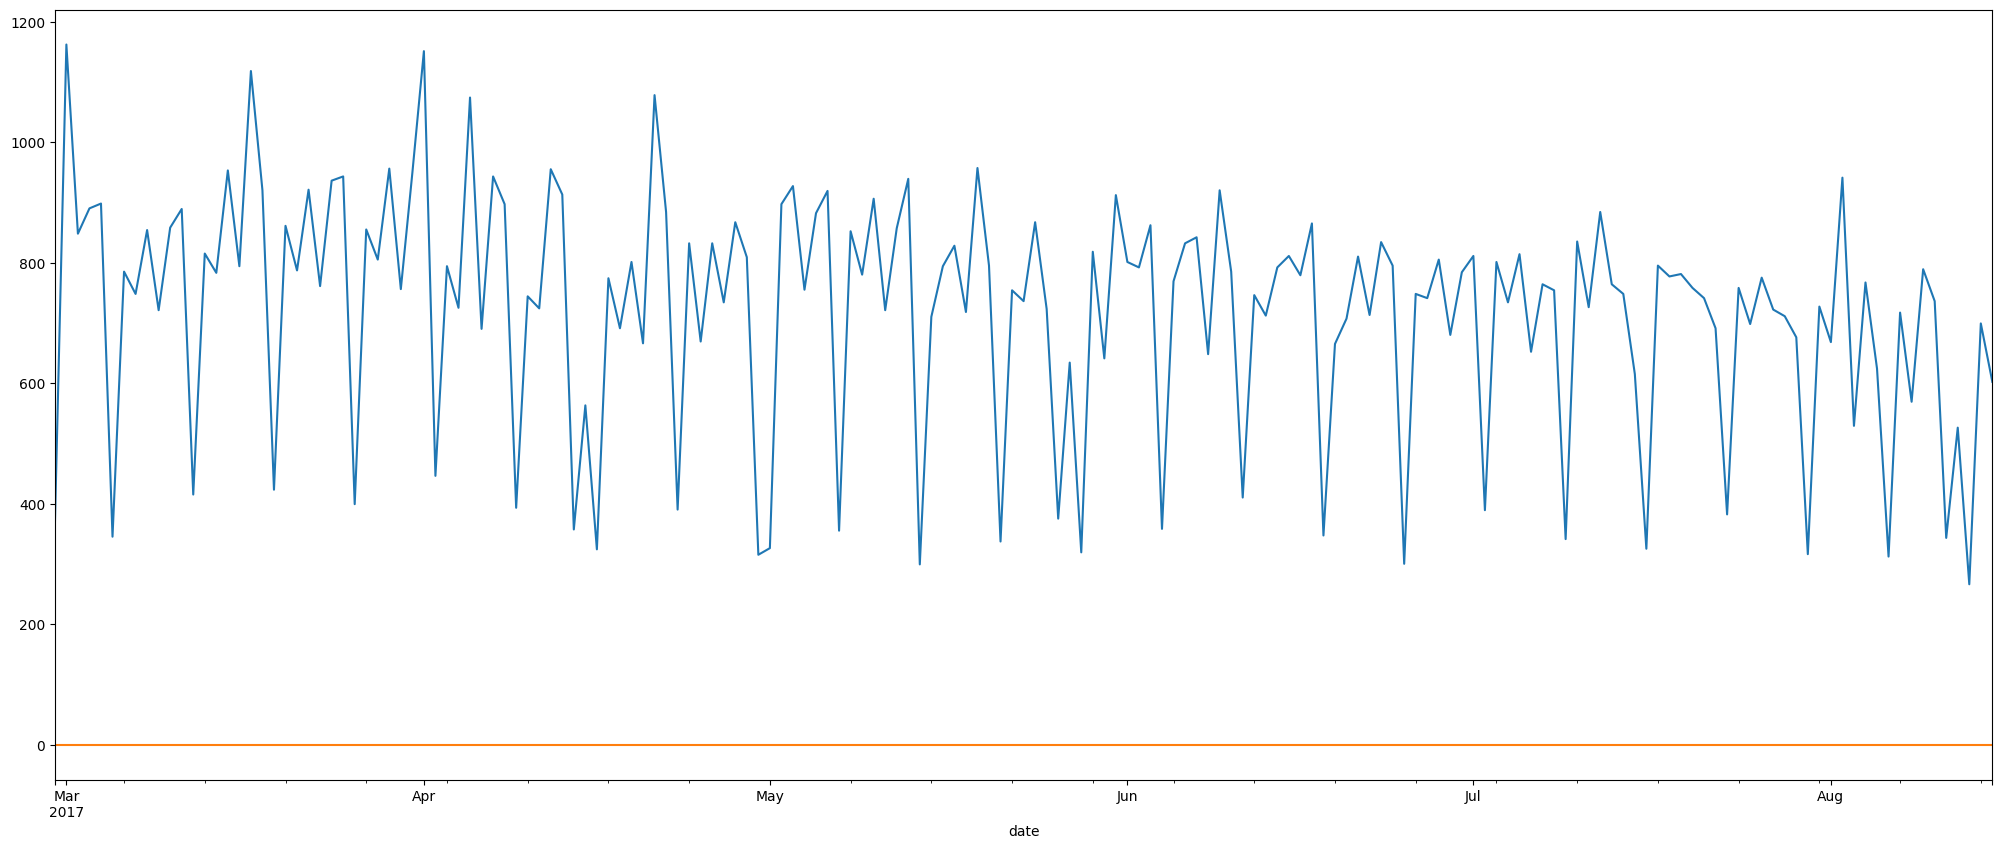

In [32]:
compare('1_DAIRY')

R2 Score: -8.795329571343473
RMSLE: 2.41738232110234


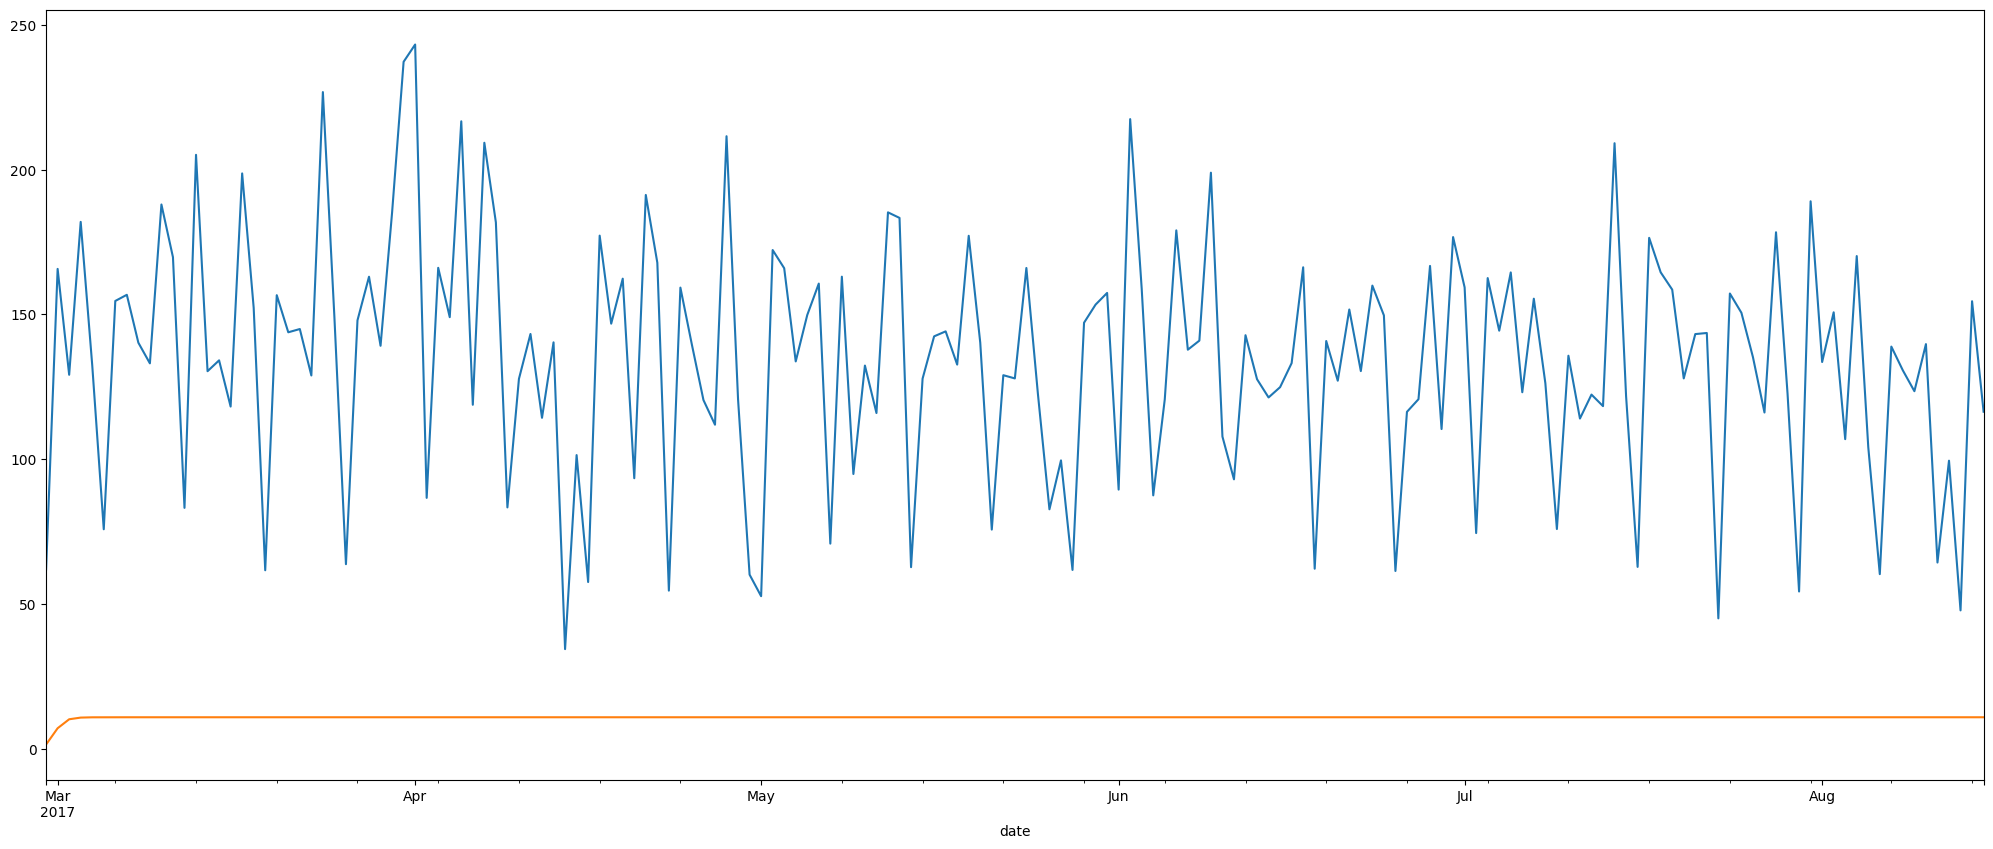

In [33]:
compare('1_DELI')

## Exog concatenated with train as X